#### Imports and helper functions

In [1]:
#! /usr/bin/env python3
import rospkg
import numpy as np
import pandas as pd
np.seterr(divide='ignore', invalid='ignore')
import copy
import cv2
from tqdm.auto import tqdm

from pyaarapsi.vpr_simple.vpr_helpers       import FeatureType
from pyaarapsi.vpr_simple.vpr_dataset_tool  import VPRDatasetProcessor
from pyaarapsi.vpr_simple.svm_model_tool    import SVMModelProcessor
from pyaarapsi.core.helper_tools            import m2m_dist, angle_wrap, angle_wrap
from pyaarapsi.core.ros_tools               import rip_bag, compressed2np, pose2xyw
from pyaarapsi.core.enum_tools              import enum_name
from pyaarapsi.core.transforms              import apply_homogeneous_transform, homogeneous_transform, Transform_Builder
from pyaarapsi.pathing.basic                import calc_path_stats
from pyaarapsi.vpred.vpred_tools            import find_vpr_performance_metrics

import scipy.stats
from scipy import ndimage
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
%matplotlib inline

import scienceplots
plt.style.use('ieee')

def try_convert_compressed(img):
    try:
        return compressed2np(img)
    except AttributeError:
        return None
    
def try_convert_odom(odom):
    try:
        return pose2xyw(odom.pose.pose)
    except AttributeError:
        return None
    
def make_ht(xyw):
    H_lin    = homogeneous_transform(r=0, p=0, y=0,       X=-xyw[0], Y=-xyw[1], Z=0)
    H_rot    = homogeneous_transform(r=0, p=0, y=-xyw[2], X=0,       Y=0,       Z=0)
    H        = np.matmul(H_rot, H_lin)
    return H

def get_dataset_pose(ip, ind):
    return [ip.dataset['dataset']['px'][ind], ip.dataset['dataset']['py'][ind], ip.dataset['dataset']['pw'][ind]]

def sum_dist(sum_arr, ind_1, ind_2):
    dist_1 = abs(sum_arr[ind_1] - sum_arr[ind_2])
    dist_2 = abs(sum_arr[np.max([ind_1,ind_2])] - sum_arr[-1]) + abs(sum_arr[0] - sum_arr[np.min([ind_1,ind_2])])
    return np.min([dist_1, dist_2])

def find_goal(xy__, ind_, dist_):
    num_points = xy__.shape[0]
    for i in range(num_points):
        ind_c = (ind_ + i) % num_points
        d_ = np.sqrt(np.sum(np.square(xy__[ind_,:] - xy__[ind_c,:]),0))
        if d_ > dist_:
            return(d_, ind_c)

def make_split_axes_y_linlog(_fig, _axes, _lims, _plotter, _logplotter=None, _subplot=111, _size=1):
    # Configure base axis as linear:
    _axes.set_yscale('linear')
    _axes.set_ylim((_lims[0], _lims[1]))

    # Generate, attach, and configure a secondary logarithmic axis:
    _axes_divider = make_axes_locatable(_axes)
    _axeslog = _axes_divider.append_axes("top", size=_size, pad=0, sharex=_axes)
    _axeslog.set_yscale('log')
    _axeslog.set_ylim((_lims[1]+0.001*_lims[1], _lims[2])) # add a miniscule amount to the start to prevent duplicated axis labels

    # Plot the data in both axes:
    _plotter(_axes)
    if _logplotter is None:
        _plotter(_axeslog)
    else:
        _logplotter(_axeslog)

    # Hide middle bar:
    _axes.spines['top'].set_visible(False)
    _axeslog.spines['bottom'].set_linestyle((0,(0.1,4)))
    _axeslog.spines['bottom'].set_linewidth(2)
    _axeslog.spines['bottom'].set_color('r')
    _axeslog.xaxis.set_visible(False)

    # Create an invisible frame to provide overarching anchor positions for axis labels:
    _axes.set_ylabel('')
    _axes.set_xlabel('')
    _axeslog.set_ylabel('')
    _axeslog.set_xlabel('')
    _axesi = _fig.add_subplot(_subplot, frameon=False)
    _axesi.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    return _axeslog, _axesi

def make_split_axes_x_linlog(_fig, _axes, _lims, _plotter):
    # Configure base axis as linear:
    _axes.set_xscale('linear')
    _axes.set_xlim((_lims[0], _lims[1]))

    # Generate, attach, and configure a secondary logarithmic axis:
    _axes_divider = make_axes_locatable(_axes)
    _axeslog = _axes_divider.append_axes("right", size=1, pad=0, sharey=_axes)
    _axeslog.set_xscale('log')
    _axeslog.set_xlim((_lims[1]+0.001*_lims[1], _lims[2])) # add a miniscule amount to the start to prevent duplicated axis labels

    # Plot the data in both axes:
    _plotter(_axes)
    _plotter(_axeslog)

    # Hide middle bar:
    _axes.spines['right'].set_visible(False)
    _axeslog.spines['left'].set_linestyle((0,(0.1,4)))
    _axeslog.spines['left'].set_linewidth(2)
    _axeslog.spines['left'].set_color('r')
    _axeslog.yaxis.set_visible(False)

    # Create an invisible frame to provide overarching anchor positions for axis labels:
    _axes.set_ylabel('')
    _axes.set_xlabel('')
    _axeslog.set_ylabel('')
    _axeslog.set_xlabel('')
    _axesi = _fig.add_subplot(111, frameon=False)
    _axesi.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    return _axeslog, _axesi

def calc_ablation_stats(raw_, bad_, start_ind_, decision_ind_, data_dict_, wo_sum_, vpr_sum_, vpr_xy_, gt_pos_):
    raw_est_min             = np.argmin(raw_[start_ind_:decision_ind_]) + start_ind_                        # best-match filtered vpr by match distance
    if raw_est_min in bad_:                                                                                 # if bad:
        raw_est_pos_err     = np.nan                                                                            # then we can't do anything
        raw_est_min         = np.nan
        raw_est_sum_so_far  = np.nan
        raw_est_now_ind     = np.nan
    else:                                                                                                   # if good:
        raw_est_ind         = data_dict_['mInd'][raw_est_min]                                                   # then corresponding best-match index in ref data
        raw_est_sum_so_far  = sum_dist(wo_sum_, decision_ind_, raw_est_min)                                     # since best-match, how much movement?
        raw_est_now_ind     = np.argmin(abs(np.array(vpr_sum_) - (vpr_sum_[raw_est_ind] + raw_est_sum_so_far))) # what is current position index along the vpr path?
        raw_est_pos_now     = vpr_xy_[raw_est_now_ind,:]                                                        # what is current position?
        raw_est_pos_err     = np.sqrt(np.sum(np.square(gt_pos_    - raw_est_pos_now)))                          # how much error is in the position estimate?
    return raw_est_pos_err, raw_est_min, raw_est_now_ind, raw_est_sum_so_far

def gen_data_dict(_qry_feats, _wo_odom, _gt_odom, _ft_type, _img_dims, _ref_ip, _svm, _tol_thres, _naive_p_thresh, _naive_r_thresh, use_tqdm=True):
    # Create array of ground truth odometry (xyw), wheel encoder odometry (xyw), EKF filtered odometry (xyw), 
    # VPR match index, VPR match distance, VPR true index, VPR true distance
    # ground truth classification, ground truth error
    # SVM prediction, SVM probability, SVM z value

    # Initialise dictionary:
    _data_dict          = dict(gt_xyw=_gt_odom, wo_xyw=_wo_odom, 
                            mInd=[], mDist=[], tInd=[], tDist=[], 
                            gt_class=[], gt_err=[], 
                            svm_pred=[], svm_prob=[], svm_z=[],
                            feats=[])

    _state_hist         = np.zeros((10,3)) # state history of matched x,y,w

    if use_tqdm:
        iter_obj = tqdm(range(_qry_feats.shape[0]))
    else:
        iter_obj = range(_qry_feats.shape[0])

    for i in iter_obj:
        _new_qry        = _qry_feats[i]
        _features       = _ref_ip.dataset['dataset'][enum_name(_ft_type)]

        _dvc            = m2m_dist(_features, np.matrix(_new_qry), True)
        _squares        = np.square(np.array(_ref_ip.dataset['dataset']['px']) - _data_dict['gt_xyw'][i,0]) + \
                          np.square(np.array(_ref_ip.dataset['dataset']['py']) - _data_dict['gt_xyw'][i,1])
        _mInd           = np.argmin(_dvc)
        _tInd           = np.argmin(_squares)
        _tolError       = np.sqrt(np.square(_ref_ip.dataset['dataset']['px'][_tInd] - _ref_ip.dataset['dataset']['px'][_mInd]) + \
                                  np.square(_ref_ip.dataset['dataset']['py'][_tInd] - _ref_ip.dataset['dataset']['py'][_mInd]))
        _rXY             = np.stack([_ref_ip.dataset['dataset']['px'], _ref_ip.dataset['dataset']['py']], 1)
        (_pred, _zval, _factors, _prob) = _svm.predict(_dvc, _mInd, _rXY, init_pos=_state_hist[1, 0:2])
        if _pred:
            _state_hist[0,:] = [_ref_ip.dataset['dataset']['px'][_mInd], _ref_ip.dataset['dataset']['py'][_mInd], _ref_ip.dataset['dataset']['pw'][_mInd]]
            _state_hist      = np.roll(_state_hist, 1, 0)
        _data_dict['mInd'].append(    _mInd)
        _data_dict['tInd'].append(    _tInd)
        _data_dict['mDist'].append(   _dvc[_mInd])
        _data_dict['tDist'].append(   _dvc[_tInd])
        _data_dict['gt_class'].append(_tolError < _tol_thres)
        _data_dict['gt_err'].append(  _tolError)
        _data_dict['svm_pred'].append(_pred)
        _data_dict['svm_prob'].append(_prob)
        _data_dict['svm_z'].append(   _zval)
        _data_dict['feats'].append(   _new_qry)

    # Convert to numpy array:
    for k in _data_dict:
        _data_dict[k]    = np.array(_data_dict[k])

    # Apply naive thresholds:
    _data_dict['naive_p'] = []
    _data_dict['naive_r'] = []
    for mDist in _data_dict['mDist']:
        _data_dict['naive_p'].append(mDist <= _naive_p_thresh)
        _data_dict['naive_r'].append(mDist <= _naive_r_thresh)
    _data_dict['naive_p'] = np.array(_data_dict['naive_p'])
    _data_dict['naive_r'] = np.array(_data_dict['naive_r'])

    return _data_dict

def synchronise_datasets(ds1, ds2, _sample_rate):

    start_min = np.min([ds1['time'][0], ds2['time'][0]])

    ip1_t   = np.array((ds1['time'] - start_min) * (10**3),dtype=int)
    ip2_t   = np.array((ds2['time'] - start_min) * (10**3),dtype=int)
    dt      = int((1/_sample_rate) * (10**3))

    ip1_t   = np.array((ip1_t + dt/2) - ((ip1_t + dt/2) % dt), dtype=int)
    ip2_t   = np.array((ip2_t + dt/2) - ((ip2_t + dt/2) % dt), dtype=int)

    # Which numbers appear only once in each? although they may appear more often, filter those out too because it's too annoying lmao
    uv, uc  = np.unique(list(ip1_t) + list(ip2_t), return_counts=True)
    uvf     = uv[uc==2]

    inds = []
    for v in uvf:
        _i1 = np.where(ip1_t == v)[0][0]
        _i2 = np.where(ip2_t == v)[0][0]
        inds.append([_i1, _i2])
    inds = np.array(inds)

    ip1_fd = {k: ds1[k][inds[:,0]] for k in ds1.keys()}
    ip2_fd = {k: ds2[k][inds[:,1]] for k in ds2.keys()}

    return ip1_fd, ip2_fd

def mean_confidence_interval(data, confidence=0.95):
    # https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    a       = 1.0 * np.array(data)
    n       = np.count_nonzero(~np.isnan(a))
    m, se   = np.nanmean(a), scipy.stats.sem(a, nan_policy='omit')
    h       = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def make_legend_arrow(legend, orig_handle,
                      xdescent, ydescent,
                      width, height, fontsize):
    p = matplotlib.patches.FancyArrow(4, 2, 6, 0, width=1, head_width=2.5, head_length=3, length_includes_head=True, overhang=0)
    return p


#### Data generation function ...

In [2]:
def generate_data(_sample_rate, _tol_thres, _environment, _condition, _slice_lengths, _printer, _df=None, _single_frame=False):
    global bags, root_path, npz_dbp, svm_dbp, bag_dbp, odom_topic, enc_topic, img_topics, ft_type, img_dims, filters, factors, tol_mode, iVPR, iSVM, iNVP, iNVR, iGT_, mode_names

    print('Generating for', _environment, _condition)

    ref_dict        = dict( bag_name=bags[_environment][_condition]['ref'], npz_dbp=npz_dbp, bag_dbp=bag_dbp, \
                            odom_topic=odom_topic, img_topics=img_topics, sample_rate=_sample_rate, \
                            ft_types=[enum_name(ft_type)], img_dims=img_dims, filters=filters)
    qry_dict        = dict( bag_name=bags[_environment][_condition]['qry'], npz_dbp=npz_dbp, bag_dbp=bag_dbp, \
                            odom_topic=[odom_topic, enc_topic], img_topics=img_topics, sample_rate=_sample_rate, \
                            ft_types=[enum_name(ft_type)], img_dims=img_dims, filters=filters)
    svm_ref_dict    = dict( bag_name=bags[_environment]['SVM']['ref'], npz_dbp=npz_dbp, bag_dbp=bag_dbp, \
                            odom_topic=odom_topic, img_topics=img_topics, sample_rate=_sample_rate, \
                            ft_types=[enum_name(ft_type)], img_dims=img_dims, filters=filters)
    svm_qry_dict    = dict( bag_name=bags[_environment]['SVM']['qry'], npz_dbp=npz_dbp, bag_dbp=bag_dbp, \
                            odom_topic=odom_topic, img_topics=img_topics, sample_rate=_sample_rate, \
                            ft_types=[enum_name(ft_type)], img_dims=img_dims, filters=filters)
    svm_svm_dict    = dict(factors=factors, tol_thres=_tol_thres, tol_mode=tol_mode)
    svm_dict        = dict(ref=svm_ref_dict, qry=svm_qry_dict, svm=svm_svm_dict, npz_dbp=npz_dbp, bag_dbp=bag_dbp, svm_dbp=svm_dbp)

    ref_ip          = VPRDatasetProcessor(ref_dict, try_gen=True, cuda=True, use_tqdm=False, autosave=True, ros=False, init_netvlad=True, printer=_printer)
    qry_ip          = VPRDatasetProcessor(None, try_gen=True, cuda=True, use_tqdm=False, autosave=True, ros=False, printer=_printer)
    qry_ip.pass_nns(ref_ip, netvlad=True, hybridnet=False)
    qry_ip.load_dataset(qry_dict, try_gen=True)

    _qry_feats      = qry_ip.dataset['dataset'][enum_name(ft_type)]
    _gt_odom        = np.transpose(np.stack([qry_ip.dataset['dataset']['px'][:,0], qry_ip.dataset['dataset']['py'][:,0], qry_ip.dataset['dataset']['pw'][:,0]]))
    _wo_odom        = np.transpose(np.stack([qry_ip.dataset['dataset']['px'][:,1], qry_ip.dataset['dataset']['py'][:,1], qry_ip.dataset['dataset']['pw'][:,1]]))

    svm             = SVMModelProcessor(ros=False, printer=_printer)
    svm.pass_nns(ref_ip, netvlad=True, hybridnet=False)
    svm.load_model(svm_dict, try_gen=True, gen_datasets=True, save_datasets=True)
    if not (svm.cal_qry_ip.dataset_ready and svm.cal_ref_ip.dataset_ready):
        svm.load_training_data(**svm_dict)

    svm_mDist = []
    svm_gt_class = []
    svm_qry_feats      = svm.cal_qry_ip.dataset['dataset'][enum_name(ft_type)]
    svm_gt_odom        = np.transpose(np.stack([svm.cal_qry_ip.dataset['dataset']['px'], svm.cal_qry_ip.dataset['dataset']['py'], svm.cal_qry_ip.dataset['dataset']['pw']]))

    for i in range(svm_qry_feats.shape[0]):
        _new_qry        = svm_qry_feats[i]
        _features       = svm.cal_ref_ip.dataset['dataset'][enum_name(ft_type)]

        _dvc            = m2m_dist(_features, np.matrix(_new_qry), True)
        _squares        = np.square(np.array(svm.cal_ref_ip.dataset['dataset']['px']) - svm_gt_odom[i,0]) + \
                          np.square(np.array(svm.cal_ref_ip.dataset['dataset']['py']) - svm_gt_odom[i,1])
        _mInd           = np.argmin(_dvc)
        _tInd           = np.argmin(_squares)
        _tolError       = np.sqrt(np.square(svm.cal_ref_ip.dataset['dataset']['px'][_tInd] - svm.cal_ref_ip.dataset['dataset']['px'][_mInd]) + \
                                  np.square(svm.cal_ref_ip.dataset['dataset']['py'][_tInd] - svm.cal_ref_ip.dataset['dataset']['py'][_mInd]))

        svm_mDist.append(   _dvc[_mInd])
        svm_gt_class.append(_tolError < _tol_thres)

    svm_mDist    = np.array(svm_mDist)
    svm_gt_class = np.array(svm_gt_class) 

    # Determine naive thresholds:
    _d_sweep    = np.linspace(svm_mDist.min(), svm_mDist.max(), 2000)
    _p          = np.full_like(_d_sweep, np.nan)
    _r          = np.full_like(_d_sweep, np.nan)
    _b          = np.array(np.ones(svm_gt_class.shape),dtype='bool')

    for i, v in enumerate(_d_sweep):
        _match_found = svm_mDist <= v
        [_p[i], _r[i], _, _, _, _] = find_vpr_performance_metrics(_match_found, svm_gt_class, _b, verbose=False)

    _naive_p_thresh = _d_sweep[np.argmin(np.abs(_p - svm.model['perf']['precision']))]
    _naive_r_thresh = _d_sweep[np.argmin(np.abs(_r - svm.model['perf']['recall']))]

    print(_naive_p_thresh, _naive_r_thresh, svm.model['perf']['precision'], svm.model['perf']['recall'])

    # _naive_p_thresh = thresholds[_environment]['Precision']
    # _naive_r_thresh = thresholds[_environment]['Recall']

    # Generate query data:
    data_dict           = gen_data_dict(_qry_feats, _wo_odom, _gt_odom, ft_type, img_dims, ref_ip, svm, _tol_thres, _naive_p_thresh, _naive_r_thresh, use_tqdm=False)

    _len_queries        = len(data_dict['mInd'])

    wo_sum, wo_len      = calc_path_stats(data_dict['wo_xyw'][:,0:2])

    dd_ind_min          = np.argmin(abs(wo_sum - np.max(_slice_lengths))) + 1
    dd_ind_max          = _len_queries

    _len = qry_ip.dataset['dataset']['px'].shape[0]
    print('Using indices %d to %d (%0.2f%% of %d)' % (dd_ind_min, dd_ind_max, (100 * (dd_ind_max - dd_ind_min) / _len), _len))

    vpr_xy              = np.transpose(np.stack([ref_ip.dataset['dataset']['px'], ref_ip.dataset['dataset']['py']]))
    vpr_sum, vpr_len    = calc_path_stats(vpr_xy)

    svm_raw             = copy.deepcopy(data_dict['mDist'])
    svm_bad             = np.arange(_len_queries)[np.array(data_dict['svm_pred']) == False]
    svm_raw[svm_bad]    = np.max(svm_raw)   

    nvp_raw             = copy.deepcopy(data_dict['mDist'])
    nvp_bad             = np.arange(_len_queries)[np.array(data_dict['naive_p']) == False]
    nvp_raw[nvp_bad]    = np.max(nvp_raw) 

    nvr_raw             = copy.deepcopy(data_dict['mDist'])
    nvr_bad             = np.arange(_len_queries)[np.array(data_dict['naive_r']) == False]
    nvr_raw[nvr_bad]    = np.max(nvr_raw)

    if _df is None:
        data_frame      = pd.DataFrame(columns=['pos_error', 'mInd', 'lInd', 'wo_dist', 'mode', 'MODE', 'possible', 'slice_length', 'decision_index', 'start_index', 
                                                'environment', 'condition', 'tol_thres'], 
                                    index=list(range(_slice_lengths.shape[0] * (dd_ind_max - dd_ind_min) * 4)))
    else:
        data_frame      = _df

    df_counter = 0
    for slice_length in _slice_lengths:
        for decision_ind in range(dd_ind_min,dd_ind_max):

            if not _single_frame:
                # Search to find start index; only look at matches since then:
                start_ind           = np.argmin(abs(np.array(wo_sum) - (wo_sum[decision_ind] - slice_length)))
                while abs(wo_sum[decision_ind] - wo_sum[start_ind]) < slice_length:
                    start_ind       = start_ind - 1
            else:
                start_ind = decision_ind - 1

            # Find ground truth current position:
            gt_pos              = data_dict['gt_xyw'][decision_ind,0:2]

            # check if possible:
            possible            = True in data_dict['gt_class'][start_ind:decision_ind]

            # Ensure no silly business with indices:
            est_pos_err_list            = [None] * 4
            est_ind_list                = [None] * 4
            est_wo_dist_list            = [None] * 4
            est_now_ind_list            = [None] * 4

            est_pos_err_list[iVPR], est_ind_list[iVPR], est_now_ind_list[iVPR], est_wo_dist_list[iVPR] = calc_ablation_stats(data_dict['mDist'],      [], start_ind, decision_ind, data_dict, wo_sum, vpr_sum, vpr_xy, gt_pos)
            est_pos_err_list[iSVM], est_ind_list[iSVM], est_now_ind_list[iSVM], est_wo_dist_list[iSVM] = calc_ablation_stats(svm_raw,            svm_bad, start_ind, decision_ind, data_dict, wo_sum, vpr_sum, vpr_xy, gt_pos)
            est_pos_err_list[iNVP], est_ind_list[iNVP], est_now_ind_list[iNVP], est_wo_dist_list[iNVP] = calc_ablation_stats(nvp_raw,            nvp_bad, start_ind, decision_ind, data_dict, wo_sum, vpr_sum, vpr_xy, gt_pos)
            est_pos_err_list[iNVR], est_ind_list[iNVR], est_now_ind_list[iNVR], est_wo_dist_list[iNVR] = calc_ablation_stats(nvr_raw,            nvr_bad, start_ind, decision_ind, data_dict, wo_sum, vpr_sum, vpr_xy, gt_pos)

            # Generate pandas data frame entries:
            same_entries                            = [possible, slice_length, decision_ind, start_ind, _environment, _condition, _tol_thres]
            data_frame.iloc[(df_counter*4) + iVPR]  = [est_pos_err_list[iVPR], est_ind_list[iVPR], est_now_ind_list[iVPR], est_wo_dist_list[iVPR], 'vpr', mode_names['vpr']] + same_entries
            data_frame.iloc[(df_counter*4) + iSVM]  = [est_pos_err_list[iSVM], est_ind_list[iSVM], est_now_ind_list[iSVM], est_wo_dist_list[iSVM], 'svm', mode_names['svm']] + same_entries
            data_frame.iloc[(df_counter*4) + iNVP]  = [est_pos_err_list[iNVP], est_ind_list[iNVP], est_now_ind_list[iNVP], est_wo_dist_list[iNVP], 'nvp', mode_names['nvp']] + same_entries
            data_frame.iloc[(df_counter*4) + iNVR]  = [est_pos_err_list[iNVR], est_ind_list[iNVR], est_now_ind_list[iNVR], est_wo_dist_list[iNVR], 'nvr', mode_names['nvr']] + same_entries

            df_counter = df_counter + 1

    return data_frame, data_dict

#### Parameters

In [3]:
# Define some indices to ensure no silly business later:
iVPR = 0
iSVM = 1
iNVP = 2
iNVR = 3
iGT_ = 4

cVPR = '#C5304B'
cNVP = '#F29E4C'
cNVR = '#EFEA5A'
cSVM = '#16DB93'
cGT_ = '#048BA8'

cRED = '#e63c3c'
cBLK = 'lightgrey'

mode_names  = {'vpr': 'VPR', 'nvp': '$N_P$', 'nvr': '$N_R$', 'svm': ' SVM (Ours)', 'gt': 'Ground Truth'}
hue_order   = [mode_names['vpr'], mode_names['nvp'], mode_names['nvr'], mode_names['svm']]
set_order   = ['Office\nNormal','Office\nAdverse','Campus\nNormal','Campus\nAdverse']
_palette    = {mode_names['vpr']: cVPR, mode_names['svm']: cSVM, mode_names['nvp']: cNVP, mode_names['nvr']: cNVR, mode_names['gt']: cGT_}
#thresholds  = {'Office': {'Precision': 2442.976953677679, 'Recall': 2088.2025703881936}, 'Campus': {'Precision': 3718.4704073226553, 'Recall': 4003.259997585375}}

root_path   = rospkg.RosPack().get_path("aarapsi_robot_pack")
npz_dbp     = "/data/compressed_sets"
svm_dbp     = "/cfg/svm_models"
bag_dbp     = "/data/rosbags"
odom_topic  = "/odom/true"
enc_topic   = "/jackal_velocity_controller/odom"
img_topics  = ["/ros_indigosdk_occam/image0/compressed"]
ft_type     = FeatureType.RAW
img_dims    = [64,64]
filters     = ''
factors     = ['va', 'grad']
tol_mode    = 'DISTANCE'

good_bags   = { 'Office': 
                {   'SVM':      {'ref': 'sim_cw_3', 'qry': 'sim_cw_5'}, 
                    'Normal':   {'ref': 's5_ccw_1', 'qry': 's6_ccw_1'},
                    'Adverse':  {'ref': 's4_cw_1',  'qry': 'lab_adv_2'}},
                'Campus': 
                {   'SVM':      {'ref': 'll_cw_1',  'qry': 'll_cw_3'}, 
                    'Normal':   {'ref': 'run3_fix', 'qry': 'run4_fix'},
                    'Adverse':  {'ref': 'run1_fix', 'qry': 'run5_ccw'}}          
                }

bags        = good_bags

sample_rate = 5.0

def blank_fn(*args, **kwargs):
    pass#print(*args, *kwargs)

printer = None # blank_fn


#### Perform Experiment

In [4]:
slice_lengths       = np.array([1.5])#np.arange(0.2,10.1,0.1)

def do_experiment(_slice_lengths, _single_frame=False):
    df_ln, qd_ln = generate_data(_sample_rate=sample_rate, _tol_thres=0.5, _environment='Office', _condition='Normal',  _slice_lengths=slice_lengths, _printer=printer, _single_frame=_single_frame)
    df_la, qd_la = generate_data(_sample_rate=sample_rate, _tol_thres=0.5, _environment='Office', _condition='Adverse', _slice_lengths=slice_lengths, _printer=printer, _single_frame=_single_frame)
    df_cn, qd_cn = generate_data(_sample_rate=sample_rate, _tol_thres=1.0, _environment='Campus', _condition='Normal',  _slice_lengths=slice_lengths, _printer=printer, _single_frame=_single_frame)
    df_ca, qd_ca = generate_data(_sample_rate=sample_rate, _tol_thres=1.0, _environment='Campus', _condition='Adverse', _slice_lengths=slice_lengths, _printer=printer, _single_frame=_single_frame)

    df = pd.concat([df_cn, df_ca, df_ln, df_la])

    # Extra columns:
    df['in_tol']    = (df['pos_error'] < df['tol_thres'])
    df['discard']   = df['pos_error'].isnull() 
    df['success']   = df['in_tol'] & (df['discard'] == False)
    df['set']       = df['environment'] + '\n' + df['condition']

    df['TN'] = (df['possible']==False) & (df['discard']==True )
    df['FN'] = (df['possible']==True ) & (df['discard']==True )
    df['TP'] = (df['possible']==True ) & (df['discard']==False)
    df['FP'] = (df['possible']==False) & (df['discard']==False)

    _len = len(df['TN'])
    _type = np.array([' '*3] * _len)
    _type[np.arange(_len)[df['TN']]] = 'TN'
    _type[np.arange(_len)[df['FN']]] = 'FN'
    _type[np.arange(_len)[df['TP']]] = 'TP'
    _type[np.arange(_len)[df['FP']]] = 'FP'
    df['type'] = _type

    _TYPE = np.array([' '*16] * _len)
    _TYPE[np.arange(_len)[df['TN']]] = 'True\nNegative'
    _TYPE[np.arange(_len)[df['FN']]] = 'False\nNegative'
    _TYPE[np.arange(_len)[df['TP']]] = 'True\nPositive'
    _TYPE[np.arange(_len)[df['FP']]] = 'False\nPositive'
    df['TYPE'] = _TYPE
    return df, qd_ln, qd_la, qd_cn, qd_ca

print('Running experiment in extended slice mode')
df, qd_ln, qd_la, qd_cn, qd_ca  = do_experiment(slice_lengths, False)
df['single_frame'] = False
print('Running experiment in single frame mode')
dfS, qd_lnS, qd_laS, qd_cnS, qd_caS  = do_experiment(slice_lengths, True)
dfS['single_frame'] = True

Running experiment in extended slice mode
Generating for Office Normal
[INFO] [VPRDatasetProcessor] Loading model from parameters...
[INFO] [VPRDatasetProcessor] [load_dataset] Loading dataset.
[INFO] [VPRDatasetProcessor] Dataset Ready (loaded: dataset_20231031).
[INFO] [VPRDatasetProcessor] Ready; no dataset loaded.
[INFO] [VPRDatasetProcessor] [load_dataset] Loading dataset.
[INFO] [VPRDatasetProcessor] Ready; no dataset loaded.
[INFO] [VPRDatasetProcessor] Ready; no dataset loaded.
[INFO] [VPRDatasetProcessor] [SVMModelProcessor] Processor Ready.
[INFO] [VPRDatasetProcessor] [load_model] Loading model.
[INFO] [VPRDatasetProcessor] [load_dataset] Loading dataset.
[INFO] [VPRDatasetProcessor] [load_dataset] Loading dataset.
2361.517776088603 2758.4955466738547 0.6859205776173285 0.6375838926174496
Using indices 32 to 755 (95.76% of 755)
Generating for Office Adverse
[INFO] [VPRDatasetProcessor] Loading model from parameters...
[INFO] [VPRDatasetProcessor] [load_dataset] Loading datas

#### Generate Plots

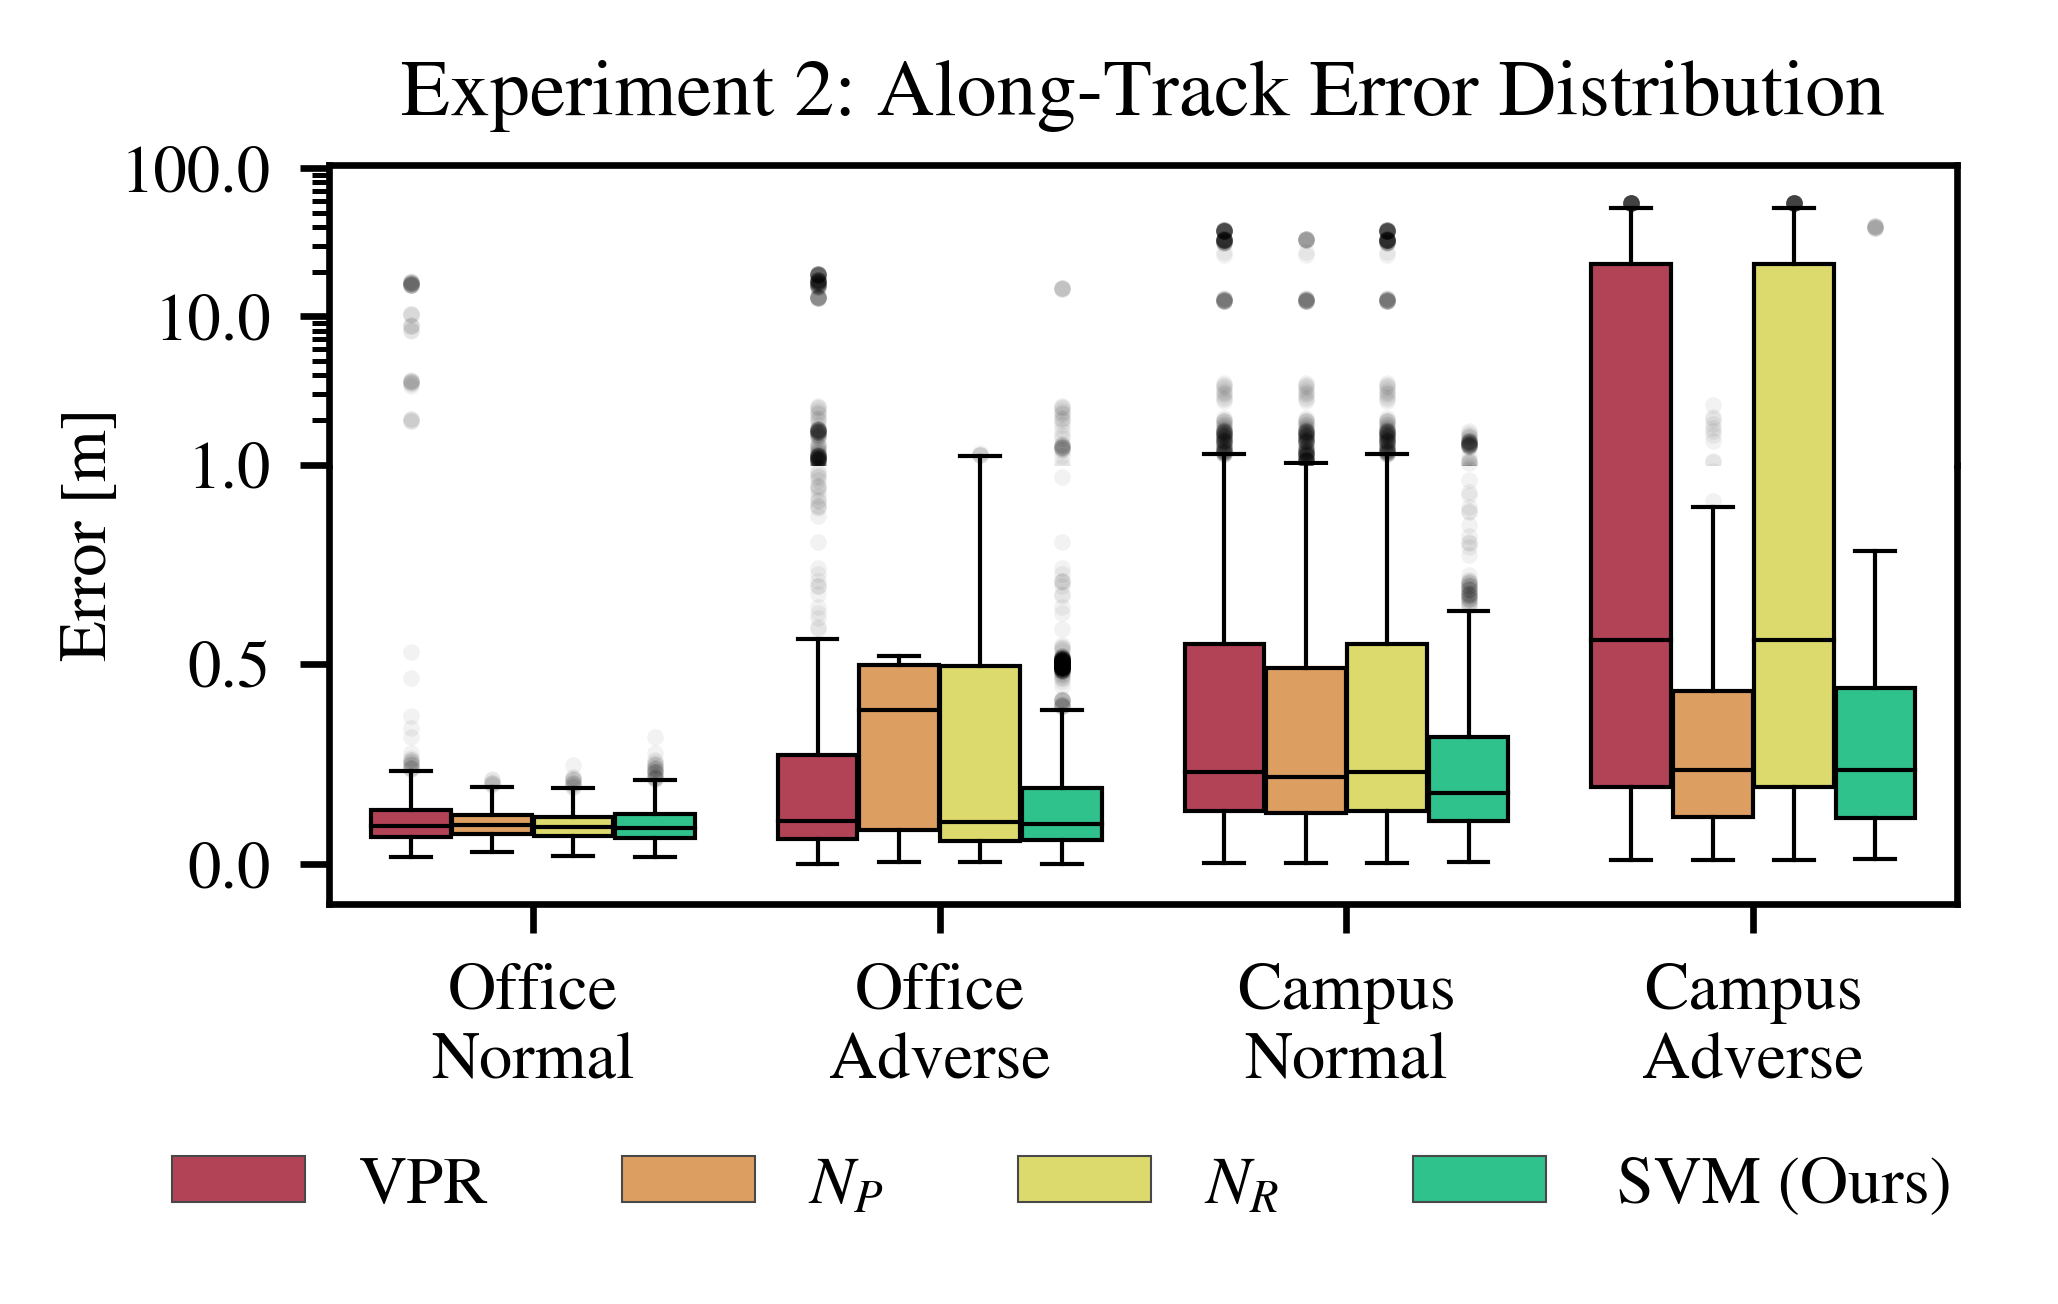

In [5]:
fig_22, axes_22         = plt.subplots(1,1,figsize=(3.5,1.6))

axes_22_plotter         = lambda ax: sns.boxplot(data=df[(df['slice_length']*10).astype(int).isin([15])], 
                                                 y='pos_error',x='set',hue='MODE',ax=ax, palette=_palette,
                                                 hue_order=hue_order, order=set_order, linewidth=0.5, width=0.8,
                                                 flierprops=dict(alpha=.05, marker='.', markersize=4, markeredgecolor='none', markerfacecolor='k'),
                                                 capprops=dict(color='k'),
                                                 boxprops=dict(edgecolor='k'), whiskerprops=dict(color='k'), medianprops=dict(color='k'))
axes_22log, axes_22i    = make_split_axes_y_linlog(fig_22, axes_22, [-0.1, 1, 105], axes_22_plotter, _size=0.5)

_formatter              = ticker.FormatStrFormatter("%0.1f")
axes_22log.yaxis.set_major_formatter(_formatter)

axes_22i.set_ylabel('Error [m]',  labelpad=8)

axes_22log.spines['bottom'].set_visible(False) # hide red dash
axes_22log.get_legend().set_visible(False)
axes_22.get_legend().set_visible(False)

lgnd = axes_22.legend(loc='lower center', frameon=False, ncol=4, bbox_to_anchor=(0.45,-0.85))

fig_22.canvas.draw()

axes_22i.set_title('Experiment 2: Along-Track Error Distribution')

path = 'media/exp2_key_results' #relative to file directory
fig_22.savefig(path+'.pdf', format='pdf', bbox_extra_artists=(lgnd,), dpi=1000, pad_inches=0, bbox_inches='tight')
fig_22.savefig(path+'.png', format='png', bbox_extra_artists=(lgnd,), dpi=1000, pad_inches=0, bbox_inches='tight')

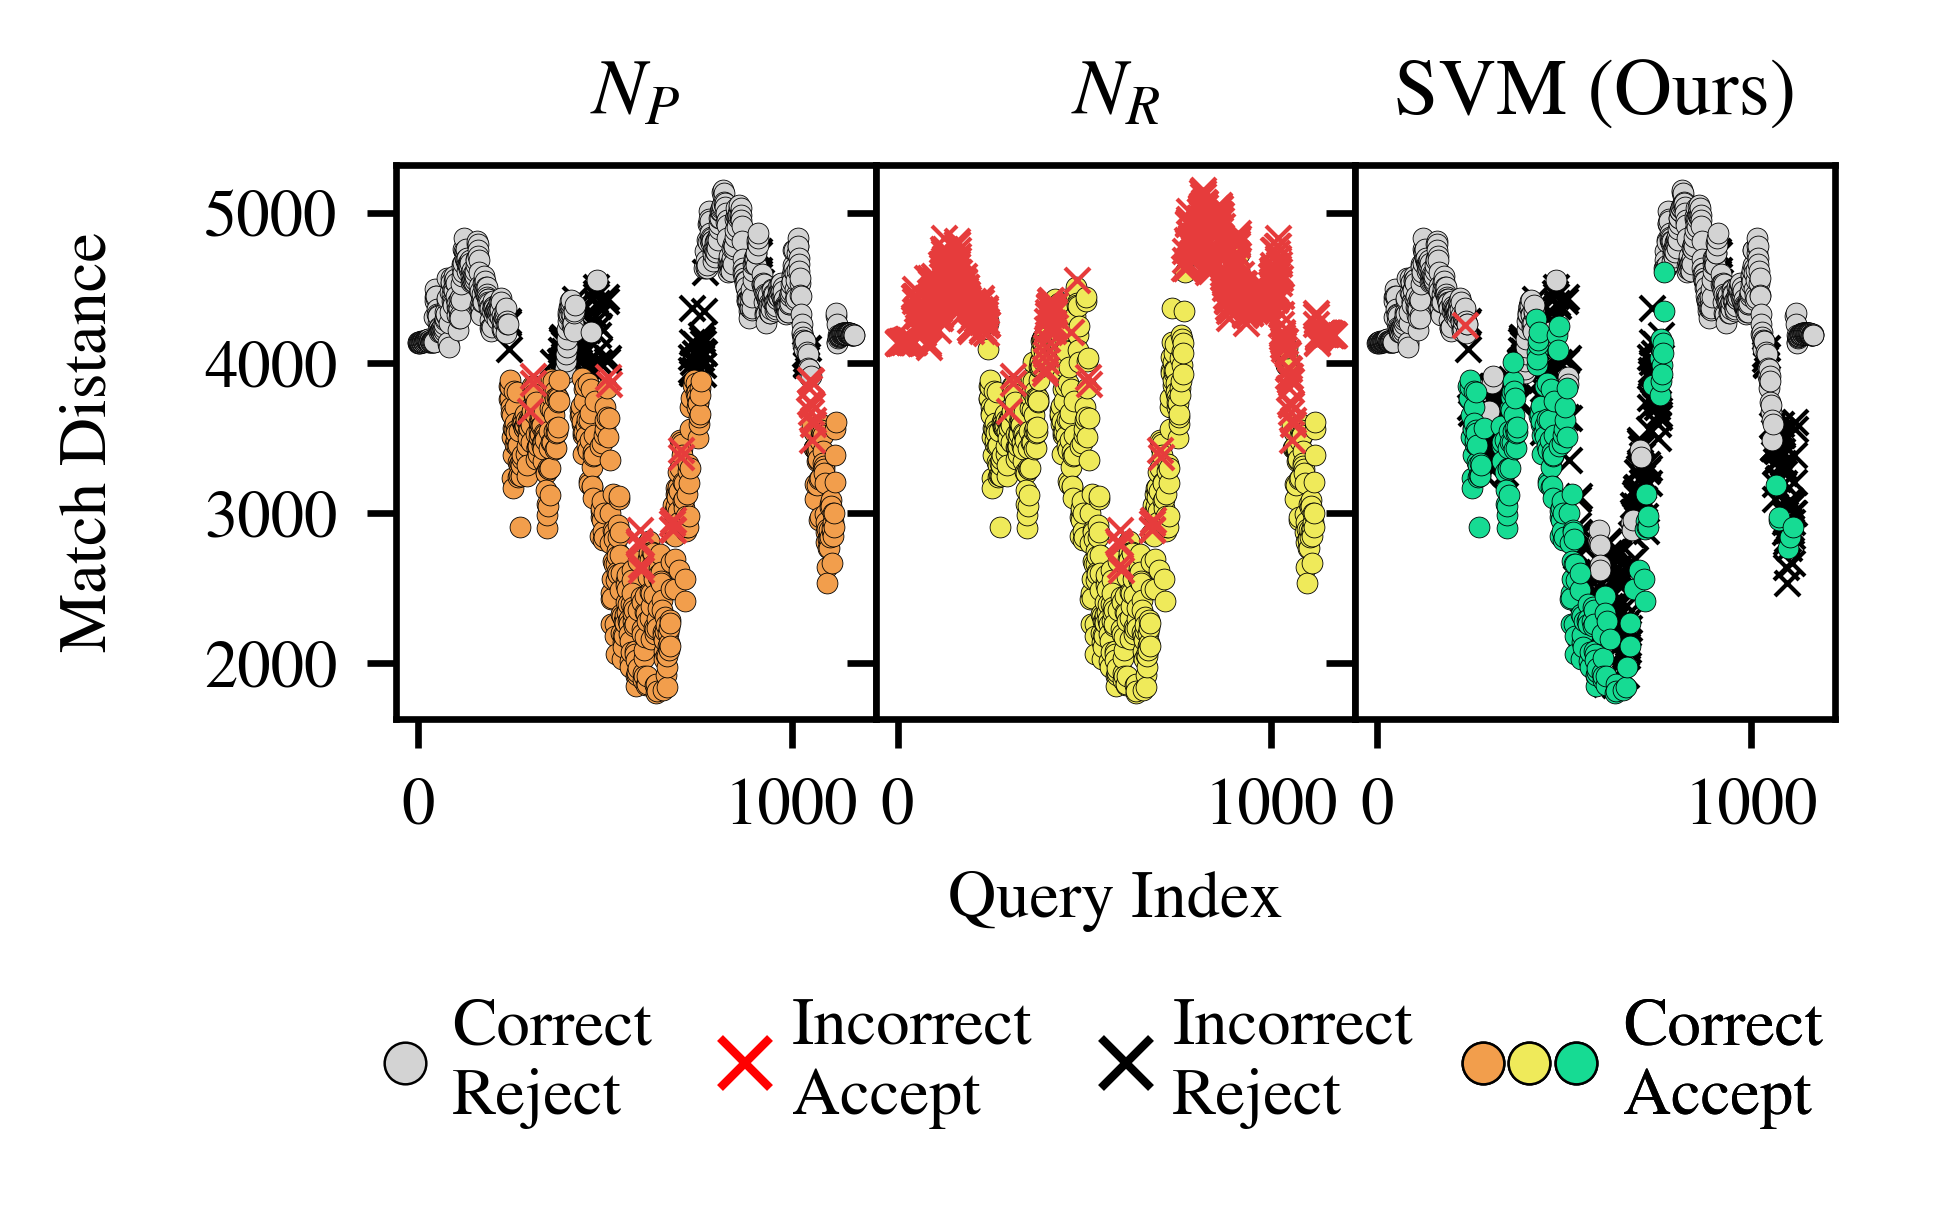

In [6]:
fig_1, axes_1           = plt.subplots(1,3, figsize=(3,1.4), sharex=True, sharey=True)
fig_1.tight_layout()

qd  = qd_ca
len_queries = len(qd['mInd'])

svm_tn_points   = (qd['svm_pred'] == qd['gt_class']) & (qd['svm_pred'] == False)
svm_tp_points   = (qd['svm_pred'] == qd['gt_class']) &  qd['svm_pred']
svm_fn_points   = (qd['svm_pred'] != qd['gt_class']) & (qd['svm_pred'] == False)
svm_fp_points   = (qd['svm_pred'] != qd['gt_class']) &  qd['svm_pred']

nvp_tn_points   = (qd['naive_p'] == qd['gt_class']) & (qd['naive_p'] == False)
nvp_tp_points   = (qd['naive_p'] == qd['gt_class']) &  qd['naive_p']
nvp_fn_points   = (qd['naive_p'] != qd['gt_class']) & (qd['naive_p'] == False)
nvp_fp_points   = (qd['naive_p'] != qd['gt_class']) &  qd['naive_p']

nvr_tn_points   = (qd['naive_r'] == qd['gt_class']) & (qd['naive_r'] == False)
nvr_tp_points   = (qd['naive_r'] == qd['gt_class']) &  qd['naive_r']
nvr_fn_points   = (qd['naive_r'] != qd['gt_class']) & (qd['naive_r'] == False)
nvr_fp_points   = (qd['naive_r'] != qd['gt_class']) &  qd['naive_r']

fna = 1.0
tna = 1.0
tpa = 1.0
fpa = 1.0
ms1 = 5.0
ms2 = 3.0

__fnm = axes_1[0].plot(np.arange(len_queries)[nvp_fn_points], qd['mDist'][nvp_fn_points],       'x',  alpha=fna, markersize=ms2, color='k', markeredgewidth=0.5)
__tnm = axes_1[0].plot(np.arange(len_queries)[nvp_tn_points], qd['mDist'][nvp_tn_points],       '.',  alpha=tna, markersize=ms1, color='k', markerfacecolor=cBLK, markeredgewidth=0.1)
_nvpm = axes_1[0].plot(np.arange(len_queries)[nvp_tp_points], qd['mDist'][nvp_tp_points],       '.',  alpha=tpa, markersize=ms1, color='k', markerfacecolor=cNVP, markeredgewidth=0.1)
__fpm = axes_1[0].plot(np.arange(len_queries)[nvp_fp_points], qd['mDist'][nvp_fp_points],       'x',  alpha=fpa, markersize=ms2, color=cRED, markeredgewidth=0.5)

axes_1[1].plot(np.arange(len_queries)[nvr_fn_points], qd['mDist'][nvr_fn_points],       'x',  alpha=fna, markersize=ms2, color='k', markeredgewidth=0.5)
axes_1[1].plot(np.arange(len_queries)[nvr_tn_points], qd['mDist'][nvr_tn_points],       '.',  alpha=tna, markersize=ms1, color='k', markerfacecolor=cBLK, markeredgewidth=0.1)
_nvrm = axes_1[1].plot(np.arange(len_queries)[nvr_tp_points], qd['mDist'][nvr_tp_points],       '.',  alpha=tpa, markersize=ms1, color='k', markerfacecolor=cNVR, markeredgewidth=0.1)
axes_1[1].plot(np.arange(len_queries)[nvr_fp_points], qd['mDist'][nvr_fp_points],       'x',  alpha=fpa, markersize=ms2, color=cRED, markeredgewidth=0.5)

axes_1[2].plot(np.arange(len_queries)[svm_fn_points], qd['mDist'][svm_fn_points],       'x',  alpha=fna, markersize=ms2, color='k', markeredgewidth=0.5)
axes_1[2].plot(np.arange(len_queries)[svm_tn_points], qd['mDist'][svm_tn_points],       '.',  alpha=tna, markersize=ms1, color='k', markerfacecolor=cBLK, markeredgewidth=0.1)
_svmm = axes_1[2].plot(np.arange(len_queries)[svm_tp_points], qd['mDist'][svm_tp_points],       '.',  alpha=tpa, markersize=ms1, color='k', markerfacecolor=cSVM, markeredgewidth=0.1)
axes_1[2].plot(np.arange(len_queries)[svm_fp_points], qd['mDist'][svm_fp_points],       'x',  alpha=fpa, markersize=ms2, color=cRED, markeredgewidth=0.5)

#axes_1[0].set_xlim(1300,1690)
#axes_1[1].set_xlim(1300,1690)
#axes_1[2].set_xlim(1300,1690)

#axes_1[2].set_ylim(2000,5000)

fig_1.subplots_adjust(wspace=0, hspace=0)

legend_elements = [ Line2D([0], [0], marker='.', label='Correct Reject',           color='k',  linewidth=0, markersize=10, markerfacecolor=cBLK, markeredgewidth=0.3),
                    Line2D([0], [0], marker='.', label='$N_P$',                    color='k',  linewidth=0, markersize=10, markerfacecolor=cNVP, markeredgewidth=0.3),
                    Line2D([0], [0], marker='x', label='Incorrect Accept',         color='r',  linewidth=0, markerfacecolor='none'),
                    Line2D([0], [0], marker='.', label='$N_R$',                    color='k',  linewidth=0, markersize=10, markerfacecolor=cNVR, markeredgewidth=0.3),
                    Line2D([0], [0], marker='x', label='Incorrect Reject',         color='k',  linewidth=0, markerfacecolor='none'),
                    Line2D([0], [0], marker='.', label='SVM (Ours)',               color='k',  linewidth=0, markersize=10, markerfacecolor=cSVM, markeredgewidth=0.3)]

legend_elements_a = [ Line2D([0], [0], marker='.', label='Correct\nReject',        color='k',  linewidth=0, markersize=10, markerfacecolor=cBLK, markeredgewidth=0.3),
                      Line2D([0], [0], marker='x', label='Incorrect\nAccept',      color='r',  linewidth=0, markerfacecolor='none'),
                      Line2D([0], [0], marker='x', label='Incorrect\nReject',      color='k',  linewidth=0, markerfacecolor='none')]

legend_elements_b = [ Line2D([0], [0], marker='.', label='',                       color='k',  linewidth=0, markersize=10, markerfacecolor=cNVP, markeredgewidth=0.3),
                      Line2D([0], [0], marker='.', label='',                       color='k',  linewidth=0, markersize=10, markerfacecolor=cNVR, markeredgewidth=0.3),
                      Line2D([0], [0], marker='.', label='Correct\nAccept',        color='k',  linewidth=0, markersize=10, markerfacecolor=cSVM, markeredgewidth=0.3)]
lgnd1 = axes_1[2].add_artist(plt.legend(handles=legend_elements_a, loc='lower center', ncol=3, columnspacing=0.4, handletextpad=-0.3, frameon=False, bbox_to_anchor=(-1.0,-0.85)))
lgnd2 = axes_1[2].add_artist(plt.legend(handles=legend_elements_b, loc='lower center', ncol=3, columnspacing=-1, handletextpad=-0.3, frameon=False, bbox_to_anchor=(0.55,-0.85)))

axes_1[0].set_title('$N_P$')
axes_1[1].set_title('$N_R$')
axes_1[2].set_title('SVM (Ours)')

axes_1i = fig_1.add_subplot(111, frameon=False)
axes_1i.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axes_1i.set_ylabel('Match Distance', labelpad=12)
axes_1i.set_xlabel('Query Index')
axes_1i.set_title('')#Query Filtering Comparison on Campus Adverse')

fig_1.canvas.draw() # Generate the canvas

path = 'media/exp2_qry_classification' #relative to file directory
fig_1.savefig(path+'.pdf', format='pdf', bbox_extra_artists=(lgnd1, lgnd2), dpi=1000, pad_inches=0, bbox_inches='tight')
fig_1.savefig(path+'.png', format='png', bbox_extra_artists=(lgnd1, lgnd2), dpi=1000, pad_inches=0, bbox_inches='tight')


#### Frame-by-frame Experiment

/tmp/ipykernel_107722/4170509768.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfB['SF'][dfB['single_frame'] == True] = ''
/tmp/ipykernel_107722/4170509768.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfB['tMode'][(dfB['single_frame'] == False) & (dfB['mode'] == 'svm')] = 'Hist. SVM\n   (Ours) '


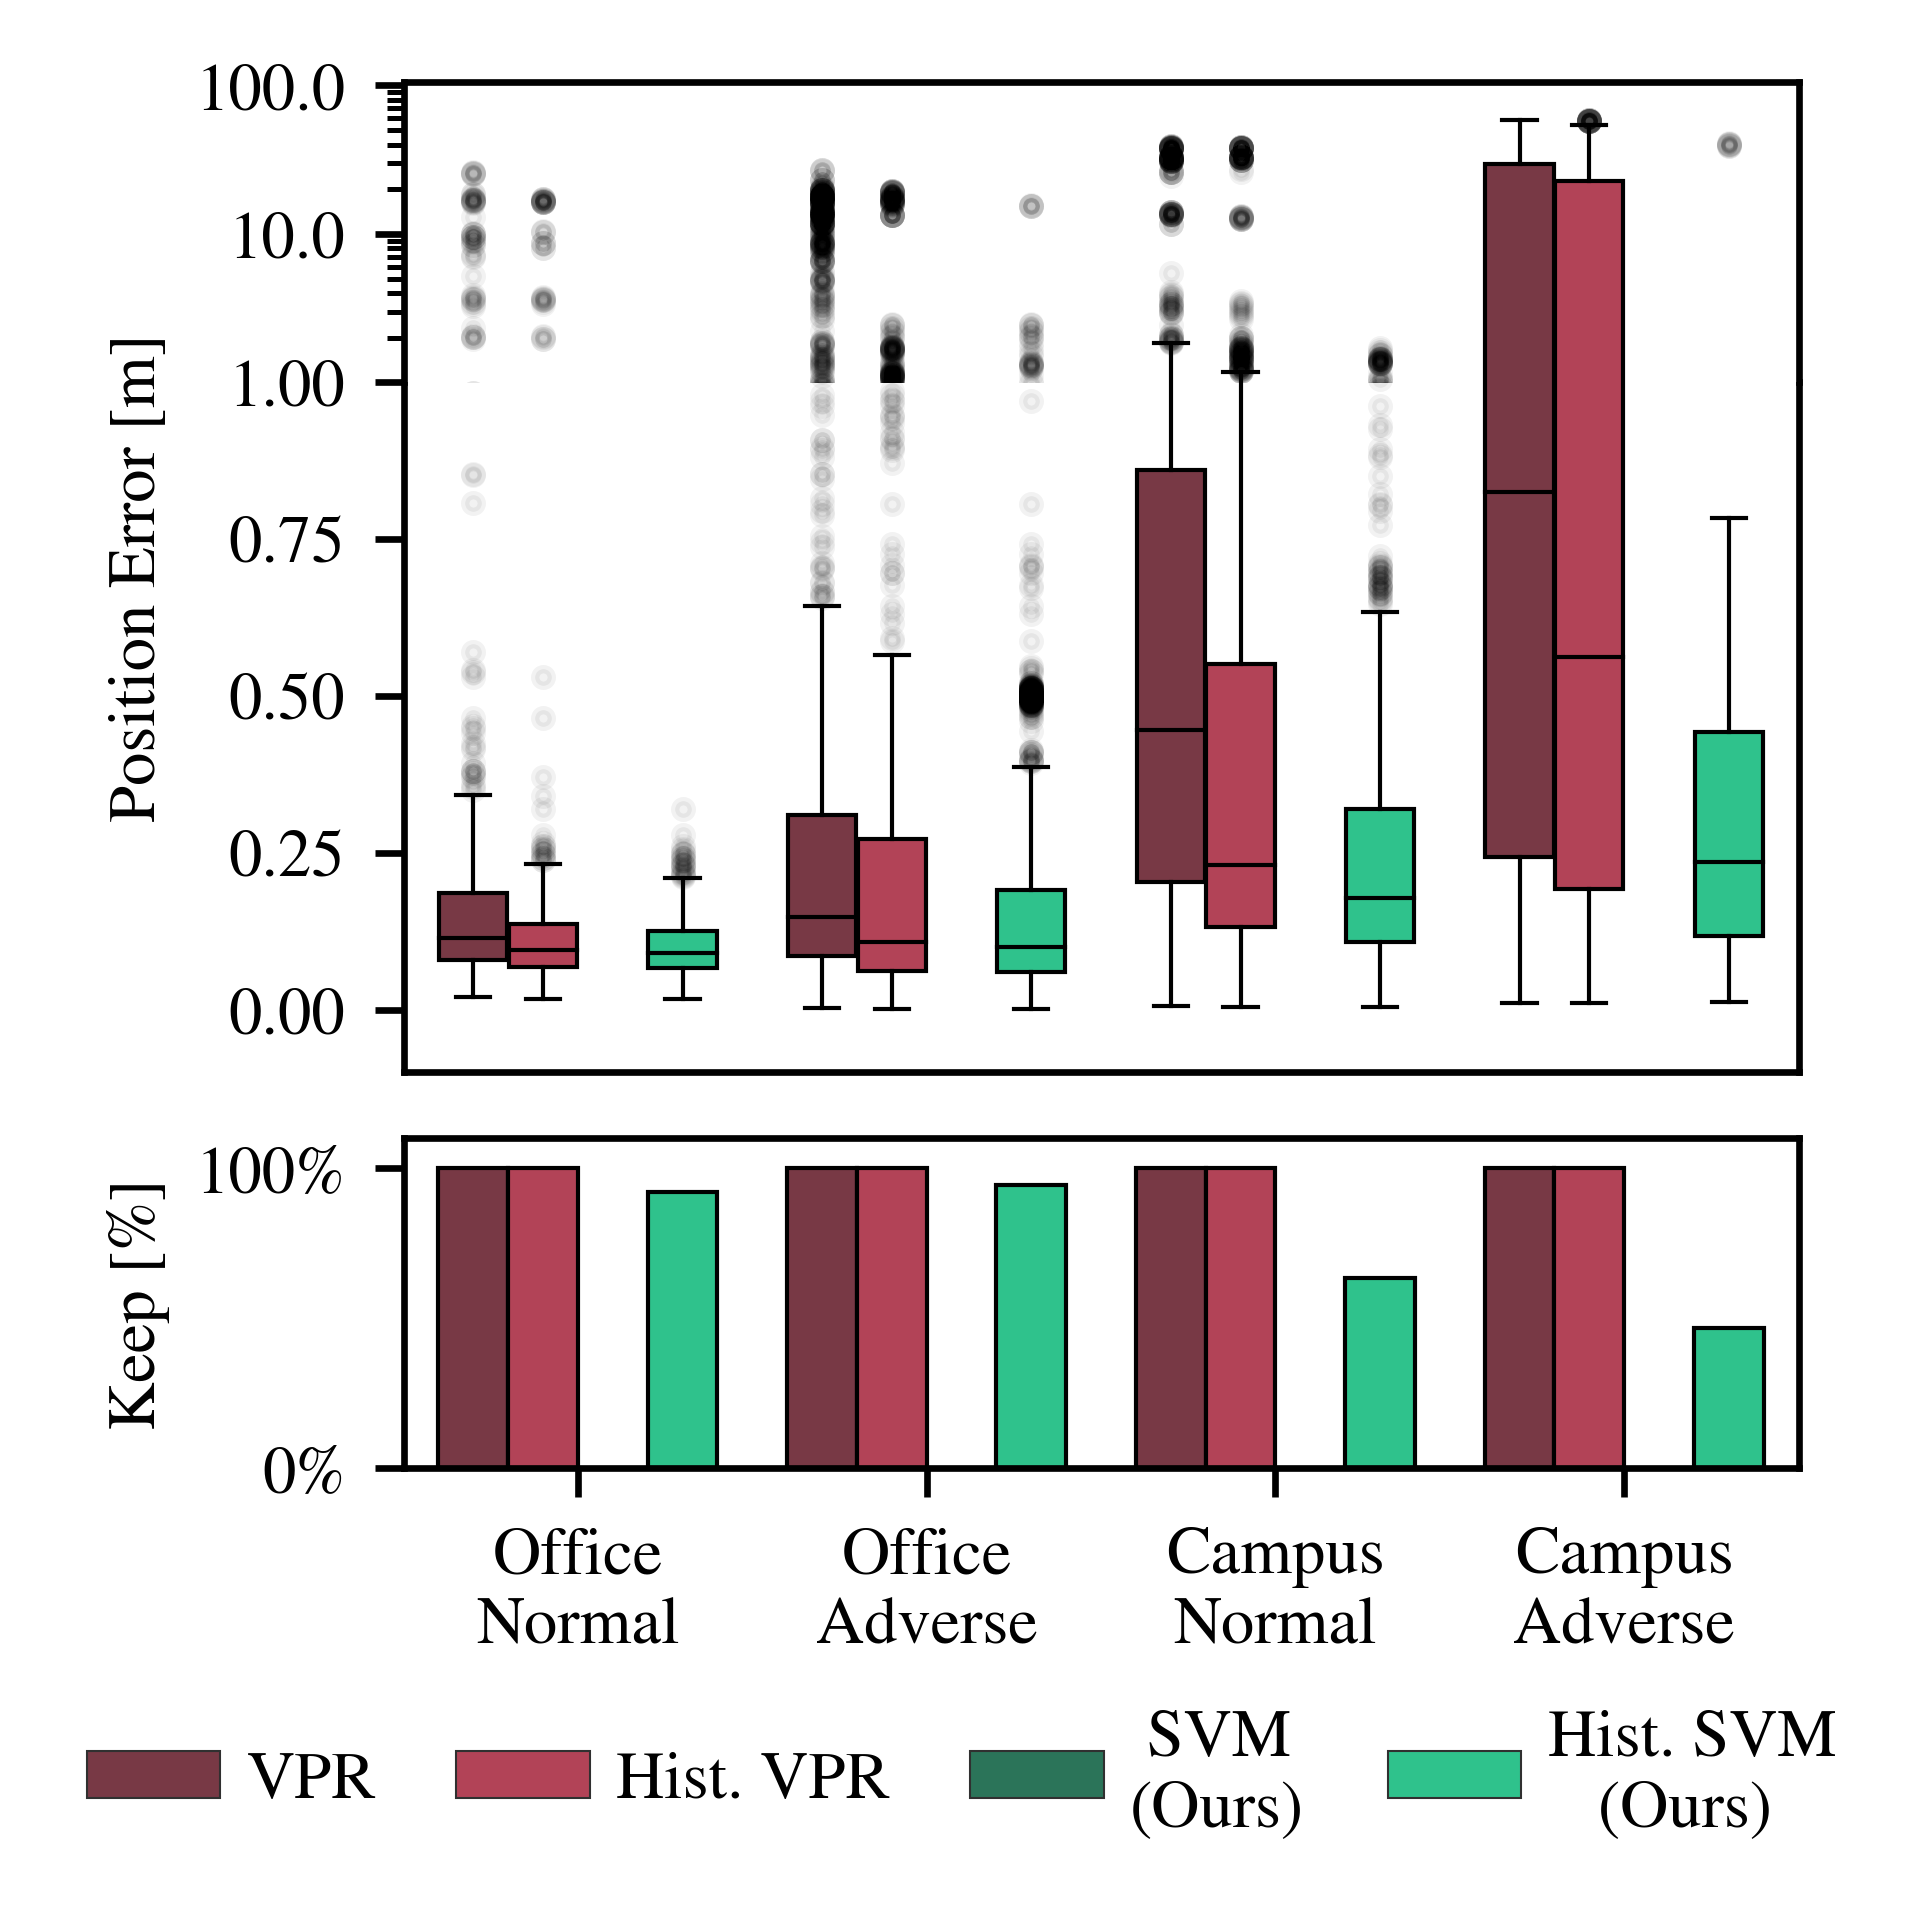

In [7]:
dfB = pd.concat([df, dfS])
dfB['SF'] = 'Hist. '
dfB['SF'][dfB['single_frame'] == True] = ''
dfB['tMode'] = dfB['SF'] + dfB['MODE']
dfB['tMode'][(dfB['single_frame'] == False) & (dfB['mode'] == 'svm')] = 'Hist. SVM\n   (Ours) '
dfB['keep'] = ~dfB['discard']
dfB['good'] = dfB['TP'] | dfB['TN']

__hue_order   = ['VPR', 'Hist. VPR', ' SVM \n(Ours)', 'Hist. SVM\n   (Ours) ']
__palette    = {'VPR': '#822F3E', ' SVM \n(Ours)': '#1F805C', 'Hist. VPR': cVPR, 'Hist. SVM\n   (Ours) ': cSVM}

_data = dfB[((dfB['mode'] == 'vpr') | (dfB['mode'] == 'svm')) & (dfB['slice_length']*10).astype(int).isin([15])]

fig_24, axes_24         = plt.subplots(2,1,figsize=(3,3), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

axes_24_plotter         = lambda ax: sns.boxplot(data=_data, 
                                                 y='pos_error',x='set',hue='tMode',ax=ax, palette={'VPR': '#822F3E', ' SVM \n(Ours)': '#1F805C', 'Hist. VPR': cVPR, 'Hist. SVM\n   (Ours) ': cSVM},
                                                 order=set_order, linewidth=0.5, width=0.8, hue_order=['VPR', 'Hist. VPR', ' SVM \n(Ours)', 'Hist. SVM\n   (Ours) '], 
                                                 flierprops=dict(alpha=.05, marker='.', markersize=4, markeredgecolor='k', markerfacecolor='k'),
                                                 capprops=dict(color='k'),
                                                 boxprops=dict(edgecolor='k'), whiskerprops=dict(color='k'), medianprops=dict(color='k'))
axes_24log, axes_24i    = make_split_axes_y_linlog(fig_24, axes_24[0], [-0.1, 1, 105, 0.1], axes_24_plotter,_subplot=211, _size=0.5)

_formatter              = ticker.FormatStrFormatter("%0.1f")
axes_24log.yaxis.set_major_formatter(_formatter)

axes_24i.set_title('')#Position Error Distribution: Instant v. Historical')
axes_24i.set_ylabel('Position Error [m]',  labelpad=11)

axes_24log.spines['bottom'].set_visible(False) # hide red dash
axes_24log.get_legend().set_visible(False)
axes_24[0].get_legend().set_visible(False) 
axes_24[0].tick_params(axis='x', which='both', bottom=False)
fig_24.subplots_adjust(wspace=0, hspace=0.1)
axes_24[0].legend(loc='lower center', frameon=False, ncol=4, bbox_to_anchor=(0.4,-1.2), columnspacing=1.2, handletextpad=0.4)

# fig_24, axes_24 = plt.subplots(2,1,figsize=(3,1.5), sharex=True)

# sns.barplot(data=_data[~pd.isna(_data['pos_error'])], estimator=np.median, 
#             y='pos_error', x='set',hue='tMode',ax=axes_24[0], palette=__palette, 
#             order=set_order, hue_order=__hue_order, 
#             edgecolor='black', linewidth=0.5, errorbar=('ci', 0))

# axes_24[0].yaxis.set_major_formatter(_formatter)
# axes_24[0].set_title('Localization Technique: Instant v. Historical')
# axes_24[0].set_xlabel('',          labelpad=0)
# axes_24[0].set_ylabel('Median Error\n[m]',  labelpad=10)
# axes_24[0].get_legend().set_visible(False)
# axes_24[0].tick_params(axis='x', which='both', bottom=False)
#axes_24[0].set_ylim(0,0.9)
#fig_24.subplots_adjust(wspace=0, hspace=0.3)
# axes_24[0].legend(loc='lower center', frameon=False, ncol=4, bbox_to_anchor=(0.4,-2.8), columnspacing=1.2, handletextpad=0.4)

sns.barplot(data=_data, 
            y='keep', x='set',hue='tMode',ax=axes_24[1], palette=__palette,#{' SVM \n(Ours)': '#1F805C', 'Hist. SVM\n   (Ours) ': cSVM}, 
            order=set_order, hue_order=__hue_order,#[' SVM \n(Ours)', 'Hist. SVM\n   (Ours) '], 
            edgecolor='black', linewidth=0.5, errorbar=('ci', 0))

axes_24[1].set_xlabel('',          labelpad=0)
axes_24[1].set_ylabel('Keep [%]', labelpad=3)
axes_24[1].yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
axes_24[1].set_ylim(0,1.1)

# axes_24[0].get_legend().set_visible(False) 
axes_24[1].get_legend().set_visible(False) 

plt.show()

#### Generate Tables

In [8]:
df_ = df[(df['slice_length']*10).astype(int).isin([15])]
datas_names = ['vpr', 'nvp', 'nvr', 'svm']#['vpr', 'cbs', 'nvp', 'nvr', 'svm']
print((' ') + (''.join(['% 10s'%i.upper() for i in datas_names])))
for i in ['Office\nNormal', 'Office\nAdverse', 'Campus\nNormal', 'Campus\nAdverse', 'All']:
    if not (i == 'All'):
        df__ = df_[(df_['set'] == i)]
    else:
        df__ = df_

    vpr_data = df__[df__['mode']=='vpr']
    cbs_data = df__[df__['mode']=='vpr'][np.array(df__[df__['mode']=='svm']['discard']==False)]
    svm_data = df__[df__['mode']=='svm']
    nvp_data = df__[df__['mode']=='nvp']
    nvr_data = df__[df__['mode']=='nvr']

    datas = [vpr_data, nvp_data, nvr_data, svm_data]#[vpr_data, cbs_data, nvp_data, nvr_data, svm_data]
    
    print(i.replace('\n',' '))

    for _type in ['FP', 'FN']:#['TP', 'FP', 'TN', 'FN']:

        scale_  = 400 / df__.shape[0]
        #print('[% 6s, % 7s] % 3s %6.2f%% %6.2f%% %6.2f%% %6.2f%%' % (_env, _cond, _type, *[scale_ * df__[df__['mode']==_mode][_type].sum() for _mode in _modes]))
        print(_type + ((' & %6.2f\\%%'*len(datas)) % tuple([scale_ * data[_type].sum() for data in datas])) + r' \\')


        VPR       NVP       NVR       SVM
Office Normal
FP &   3.73\% &   0.00\% &   0.00\% &   0.00\% \\
FN &   0.00\% &  61.13\% &  40.11\% &   4.29\% \\
Office Adverse
FP &   0.97\% &   0.00\% &   0.00\% &   0.20\% \\
FN &   0.00\% &  75.66\% &  58.93\% &   4.95\% \\
Campus Normal
FP &   5.75\% &   3.36\% &   5.75\% &   0.06\% \\
FN &   0.00\% &   3.00\% &   0.00\% &  30.95\% \\
Campus Adverse
FP &  37.74\% &   0.46\% &  37.74\% &   0.46\% \\
FN &   0.00\% &   6.94\% &   0.00\% &  16.10\% \\
All
FP &  10.15\% &   1.11\% &   9.30\% &   0.19\% \\
FN &   0.00\% &  37.95\% &  26.76\% &  14.97\% \\


In [9]:
df_ = df[(df['slice_length']*10).astype(int).isin([15])]
print((' '*13) + (''.join(['% 10s'%i.upper() for i in ['vpr', 'cbs', 'nvp', 'nvr', 'svm']])))
for i in ['Office\nNormal', 'Office\nAdverse', 'Campus\nNormal', 'Campus\nAdverse', 'All']:
    if not (i == 'All'):
        df__ = df_[(df_['set'] == i)]
    else:
        df__ = df_

    vpr_data = df__[df__['mode']=='vpr']
    cbs_data = df__[df__['mode']=='vpr'][np.array(df__[df__['mode']=='svm']['discard']==False)]
    svm_data = df__[df__['mode']=='svm']
    nvp_data = df__[df__['mode']=='nvp']
    nvr_data = df__[df__['mode']=='nvr']
    
    print(i.replace('\n',' '))
    print('     Precision' + ((' & %6.2f%%'*5) % tuple([100 * (data['TP'].sum()) / ((data['TP'].sum()) + (data['FP'].sum())) for data in [vpr_data, cbs_data, nvp_data, nvr_data, svm_data]])) + r' \\')
    print('        Recall' + ((' & %6.2f%%'*5) % tuple([100 * (data['TP'].sum()) / ((data['TP'].sum()) + (data['FN'].sum())) for data in [vpr_data, cbs_data, nvp_data, nvr_data, svm_data]])) + r' \\')
    print('      Accuracy' + ((' & %6.2f%%'*5) % tuple([100 * (data['TP'].sum() + data['TN'].sum()) / len(data)              for data in [vpr_data, cbs_data, nvp_data, nvr_data, svm_data]])) + r' \\')

                    VPR       CBS       NVP       NVR       SVM
Office Normal
     Precision &  96.27% & 100.00% & 100.00% & 100.00% & 100.00% \\
        Recall & 100.00% & 100.00% &  36.49% &  58.33% &  95.55% \\
      Accuracy &  96.27% & 100.00% &  38.87% &  59.89% &  95.71% \\
Office Adverse
     Precision &  99.03% &  99.78% & 100.00% & 100.00% &  99.78% \\
        Recall & 100.00% & 100.00% &  23.60% &  40.49% &  95.00% \\
      Accuracy &  99.03% &  99.78% &  24.34% &  41.07% &  94.85% \\
Campus Normal
     Precision &  94.25% &  99.90% &  96.44% &  94.25% &  99.90% \\
        Recall & 100.00% & 100.00% &  96.82% & 100.00% &  67.16% \\
      Accuracy &  94.25% &  99.90% &  93.64% &  94.25% &  68.99% \\
Campus Adverse
     Precision &  62.26% &  99.01% &  99.17% &  62.26% &  99.01% \\
        Recall & 100.00% & 100.00% &  88.86% & 100.00% &  74.15% \\
      Accuracy &  62.26% &  99.01% &  92.60% &  62.26% &  83.44% \\
All
     Precision &  89.85% &  99.75% &  97.90% &  87.15% &  

In [10]:
df_ = df[(df['slice_length']*10).astype(int).isin([15])]
for i in ['Office\nNormal', 'Office\nAdverse', 'Campus\nNormal', 'Campus\nAdverse', 'All']:
    if not (i == 'All'):
        df__ = df_[(df_['set'] == i)]
    else:
        df__ = df_
        
    vpr_data = df__[df__['mode']=='vpr']
    cbs_data = df__[df__['mode']=='vpr'][np.array(df__[df__['mode']=='svm']['discard']==False)]
    svm_data = df__[df__['mode']=='svm']
    nvp_data = df__[df__['mode']=='nvp']
    nvr_data = df__[df__['mode']=='nvr']

    mean_vpr, conf_vpr = mean_confidence_interval(vpr_data['pos_error'].to_numpy(dtype=float))
    medi_vpr = np.nanmedian(    vpr_data['pos_error'].to_numpy(dtype=float))
    max__vpr = np.nanpercentile(vpr_data['pos_error'].to_numpy(dtype=float), [100])[0]

    mean_cbs, conf_cbs = mean_confidence_interval(cbs_data['pos_error'].to_numpy(dtype=float))
    medi_cbs = np.nanmedian(    cbs_data['pos_error'].to_numpy(dtype=float))
    max__cbs = np.nanpercentile(cbs_data['pos_error'].to_numpy(dtype=float), [100])[0]

    mean_svm, conf_svm = mean_confidence_interval(svm_data['pos_error'].to_numpy(dtype=float))
    medi_svm = np.nanmedian(    svm_data['pos_error'].to_numpy(dtype=float))
    max__svm = np.nanpercentile(svm_data['pos_error'].to_numpy(dtype=float), [100])[0]

    mean_nvp, conf_nvp = mean_confidence_interval(nvp_data['pos_error'].to_numpy(dtype=float))
    medi_nvp = np.nanmedian(    nvp_data['pos_error'].to_numpy(dtype=float))
    max__nvp = np.nanpercentile(nvp_data['pos_error'].to_numpy(dtype=float), [100])[0]

    mean_nvr, conf_nvr = mean_confidence_interval(nvr_data['pos_error'].to_numpy(dtype=float))
    medi_nvr = np.nanmedian(    nvr_data['pos_error'].to_numpy(dtype=float))
    max__nvr = np.nanpercentile(nvr_data['pos_error'].to_numpy(dtype=float), [100])[0]

    perc_gt_ = np.round(100 *   (vpr_data['pos_error']>vpr_data['tol_thres']).sum() / len(df_[(df_['set'] == i) & (df_['mode']=='vpr')]['mode']),2)

    print('% 33s' % i.replace('\n',' '))
    print((' '*6) + ''.join(['% 10s' % i for i in ['VPR', 'CBS', 'NVP', 'NVR', 'SVM']]))
    print('& Mean', '& %6.2fm' % mean_vpr, '& %6.2fm' % mean_cbs, '& %6.2fm' % mean_nvp, '& %6.2fm' % mean_nvr, '& %6.2fm' % mean_svm, r'\\')
    print('& Med.', '& %6.2fm' % medi_vpr, '& %6.2fm' % medi_cbs, '& %6.2fm' % medi_nvp, '& %6.2fm' % medi_nvr, '& %6.2fm' % medi_svm, r'\\')
    print('& Max.', '& %6.2fm' % max__vpr, '& %6.2fm' % max__cbs, '& %6.2fm' % max__nvp, '& %6.2fm' % max__nvr, '& %6.2fm' % max__svm, r'\\')
    print('')

                    Office Normal
             VPR       CBS       NVP       NVR       SVM
& Mean &   0.62m &   0.10m &   0.10m &   0.10m &   0.10m \\
& Med. &   0.10m &   0.09m &   0.10m &   0.09m &   0.09m \\
& Max. &  17.21m &   0.53m &   0.21m &   0.25m &   0.32m \\

                   Office Adverse
             VPR       CBS       NVP       NVR       SVM
& Mean &   0.77m &   0.58m &   0.30m &   0.26m &   0.22m \\
& Med. &   0.11m &   0.10m &   0.39m &   0.11m &   0.10m \\
& Max. &  19.40m &  19.40m &   0.52m &   1.20m &  15.59m \\

                    Campus Normal
             VPR       CBS       NVP       NVR       SVM
& Mean &   1.61m &   0.30m &   0.71m &   1.61m &   0.27m \\
& Med. &   0.23m &   0.17m &   0.22m &   0.23m &   0.18m \\
& Max. &  38.34m &  37.90m &  33.09m &  38.34m &   1.70m \\

                   Campus Adverse
             VPR       CBS       NVP       NVR       SVM
& Mean &  11.80m &   0.78m &   0.31m &  11.80m &   0.92m \\
& Med. &   0.56m &   0.23m &   0.

#### Trajectory Plots

dict_keys(['gt_xyw', 'wo_xyw', 'mInd', 'mDist', 'tInd', 'tDist', 'gt_class', 'gt_err', 'svm_pred', 'svm_prob', 'svm_z', 'feats', 'naive_p', 'naive_r'])
[INFO] [VPRDatasetProcessor] Loading model from parameters...
[INFO] [VPRDatasetProcessor] [load_dataset] Loading dataset.
[INFO] [VPRDatasetProcessor] Dataset Ready (loaded: dataset_20231031).
[INFO] [VPRDatasetProcessor] Loading model from parameters...
[INFO] [VPRDatasetProcessor] [load_dataset] Loading dataset.
[INFO] [VPRDatasetProcessor] Dataset Ready (loaded: dataset_20231031_5).
[INFO] [VPRDatasetProcessor] Loading model from parameters...
[INFO] [VPRDatasetProcessor] [load_dataset] Loading dataset.
[INFO] [VPRDatasetProcessor] Dataset Ready (loaded: dataset_20231031_3).
[INFO] [VPRDatasetProcessor] Loading model from parameters...
[INFO] [VPRDatasetProcessor] [load_dataset] Loading dataset.
[INFO] [VPRDatasetProcessor] Dataset Ready (loaded: dataset_20231031_9).


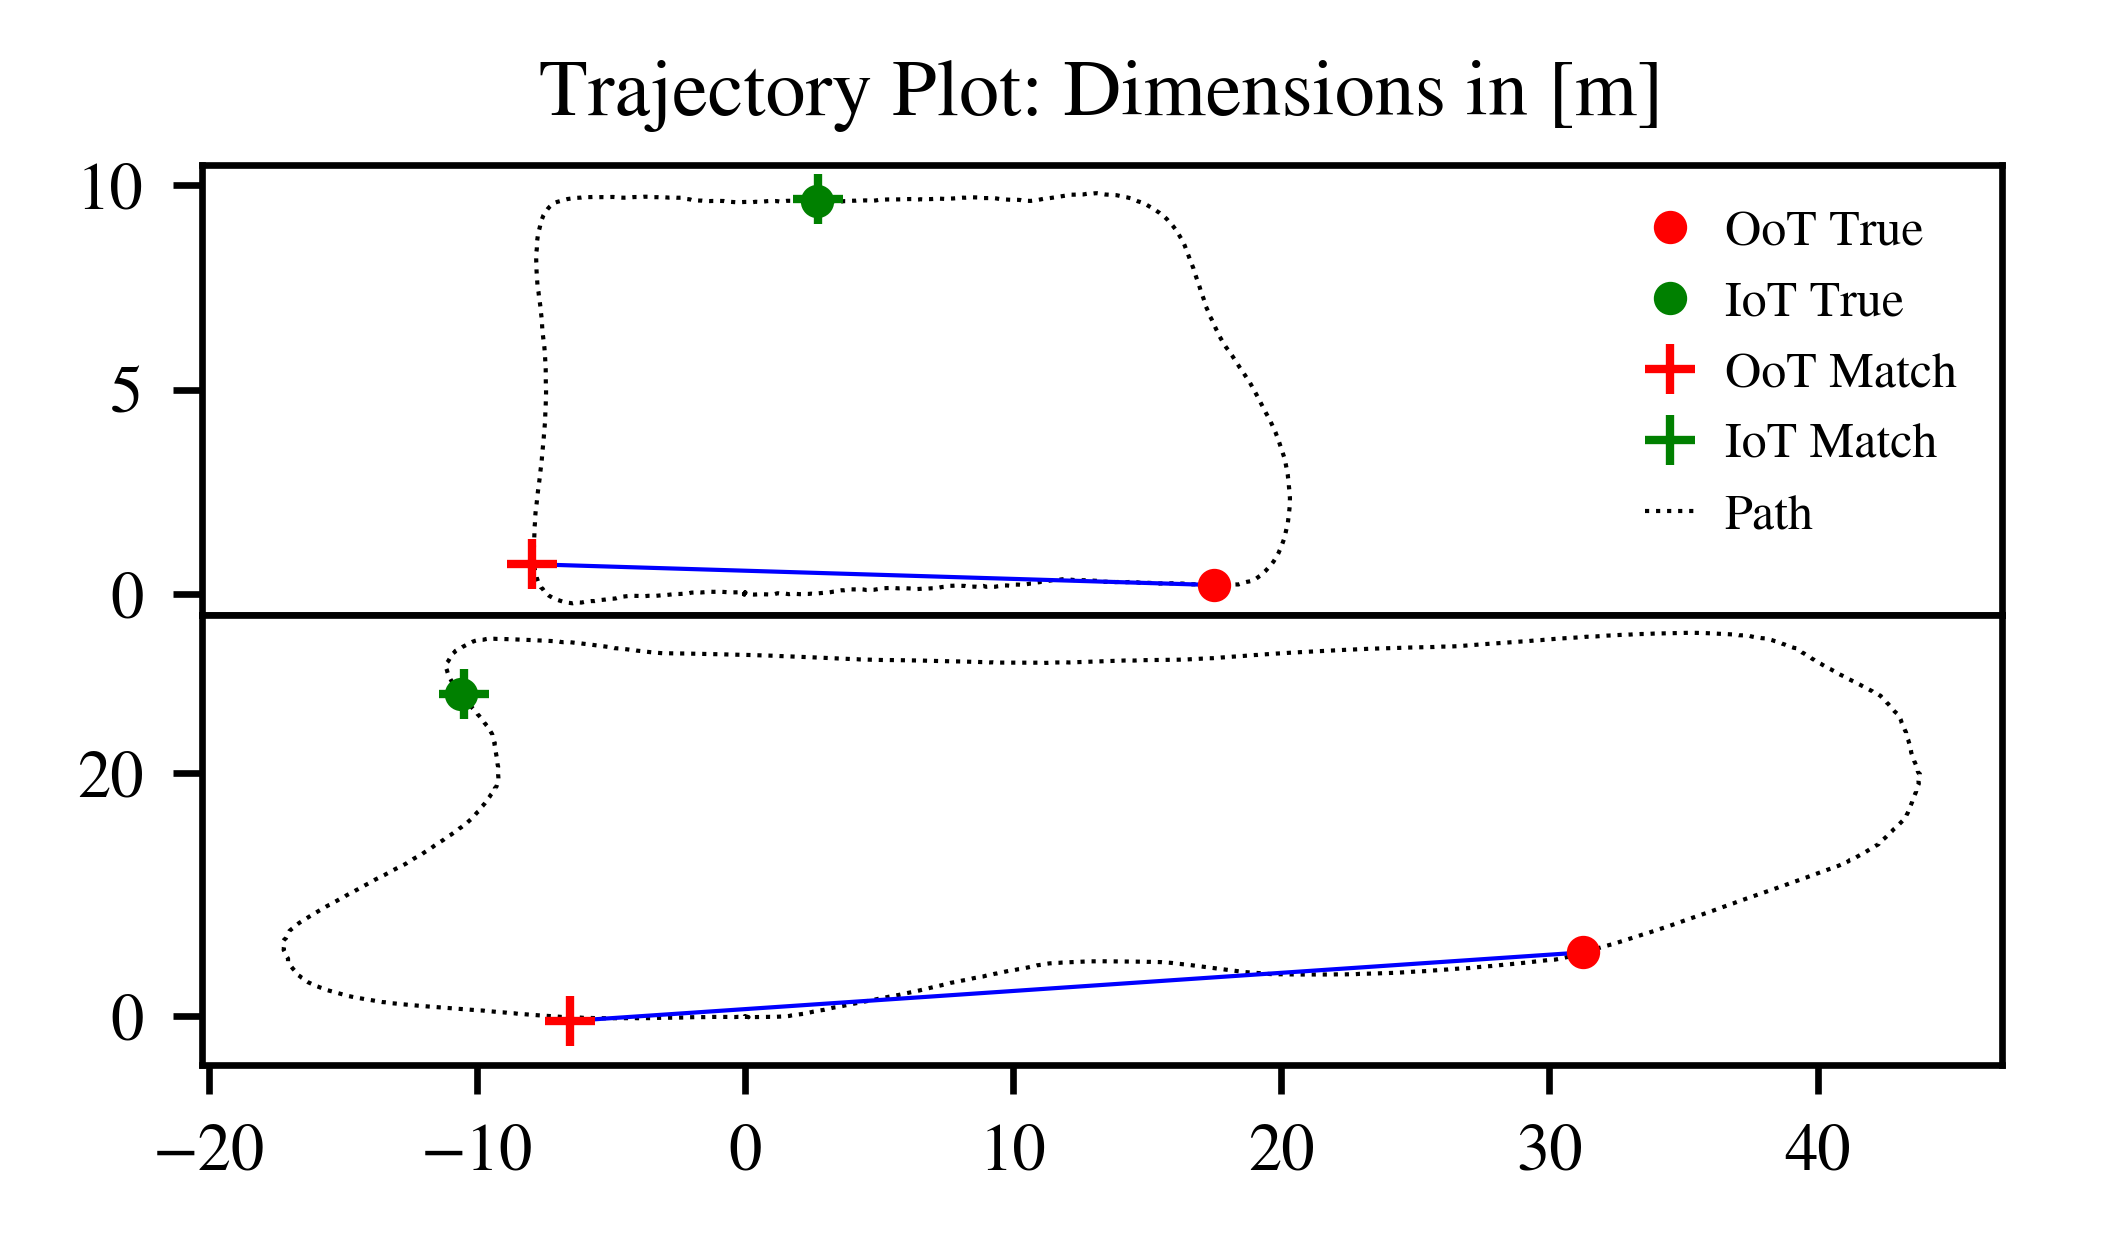

In [11]:
print(qd_ln.keys())

ln_ref_dict        = dict( bag_name=bags['Office']['Normal']['ref'], npz_dbp=npz_dbp, bag_dbp=bag_dbp, \
                        odom_topic=odom_topic, img_topics=img_topics, sample_rate=sample_rate, \
                        ft_types=[enum_name(ft_type)], img_dims=img_dims, filters=filters)
cn_ref_dict        = dict( bag_name=bags['Campus']['Normal']['ref'], npz_dbp=npz_dbp, bag_dbp=bag_dbp, \
                        odom_topic=odom_topic, img_topics=img_topics, sample_rate=sample_rate, \
                        ft_types=[enum_name(ft_type)], img_dims=img_dims, filters=filters)
la_ref_dict        = dict( bag_name=bags['Office']['Adverse']['ref'], npz_dbp=npz_dbp, bag_dbp=bag_dbp, \
                        odom_topic=odom_topic, img_topics=img_topics, sample_rate=sample_rate, \
                        ft_types=[enum_name(ft_type)], img_dims=img_dims, filters=filters)
ca_ref_dict        = dict( bag_name=bags['Campus']['Adverse']['ref'], npz_dbp=npz_dbp, bag_dbp=bag_dbp, \
                        odom_topic=odom_topic, img_topics=img_topics, sample_rate=sample_rate, \
                        ft_types=[enum_name(ft_type)], img_dims=img_dims, filters=filters)
ln_ref_ip          = VPRDatasetProcessor(ln_ref_dict, try_gen=True, cuda=True, use_tqdm=False, autosave=True, ros=False, init_netvlad=True, printer=printer)
cn_ref_ip          = VPRDatasetProcessor(cn_ref_dict, try_gen=True, cuda=True, use_tqdm=False, autosave=True, ros=False, init_netvlad=True, printer=printer)
la_ref_ip          = VPRDatasetProcessor(la_ref_dict, try_gen=True, cuda=True, use_tqdm=False, autosave=True, ros=False, init_netvlad=True, printer=printer)
ca_ref_ip          = VPRDatasetProcessor(ca_ref_dict, try_gen=True, cuda=True, use_tqdm=False, autosave=True, ros=False, init_netvlad=True, printer=printer)

fig_25, axes_25 = plt.subplots(2,1, figsize=(3,1.5), sharex=True)

ln_argmin   = np.argpartition(qd_ln['gt_err'], 20)[2]#np.argmin(qd_ln['gt_err'])
ln_argmax   = np.argpartition(qd_ln['gt_err'], -20)[-20:][15]#np.argmax(qd_ln['gt_err'])
ln_min_mPos = [ln_ref_ip.dataset['dataset']['px'][qd_ln['mInd'][ln_argmin]], ln_ref_ip.dataset['dataset']['py'][qd_ln['mInd'][ln_argmin]]]
ln_max_mPos = [ln_ref_ip.dataset['dataset']['px'][qd_ln['mInd'][ln_argmax]], ln_ref_ip.dataset['dataset']['py'][qd_ln['mInd'][ln_argmax]]]
ln_min_gPos = qd_ln['gt_xyw'][ln_argmin,0:2]
ln_max_gPos = qd_ln['gt_xyw'][ln_argmax,0:2]

cn_argmin   = np.argpartition(qd_cn['gt_err'], 20)[19]#np.argmin(qd_ln['gt_err'])
cn_argmax   = np.argpartition(qd_cn['gt_err'], -20)[-20:][1]#np.argmax(qd_ln['gt_err'])
cn_min_mPos = [cn_ref_ip.dataset['dataset']['px'][qd_cn['mInd'][cn_argmin]], cn_ref_ip.dataset['dataset']['py'][qd_cn['mInd'][cn_argmin]]]
cn_max_mPos = [cn_ref_ip.dataset['dataset']['px'][qd_cn['mInd'][cn_argmax]], cn_ref_ip.dataset['dataset']['py'][qd_cn['mInd'][cn_argmax]]]
cn_min_gPos = qd_cn['gt_xyw'][cn_argmin,0:2]
cn_max_gPos = qd_cn['gt_xyw'][cn_argmax,0:2]

# Office Normal:
axes_25[0].plot(qd_ln['gt_xyw'][:,0], qd_ln['gt_xyw'][:,1], ':', linewidth=0.5) # Trajectory
axes_25[0].plot([ln_min_gPos[0], ln_min_mPos[0]], [ln_min_gPos[1], ln_min_mPos[1]], 'b-', linewidth=0.5)
axes_25[0].plot([ln_max_gPos[0], ln_max_mPos[0]], [ln_max_gPos[1], ln_max_mPos[1]], 'b-', linewidth=0.5)
axes_25[0].plot(ln_min_gPos[0], ln_min_gPos[1], 'g.')
axes_25[0].plot(ln_max_gPos[0], ln_max_gPos[1], 'r.')
axes_25[0].plot(ln_min_mPos[0], ln_min_mPos[1], 'g+', markerfacecolor='none')
axes_25[0].plot(ln_max_mPos[0], ln_max_mPos[1], 'r+', markerfacecolor='none')

# Campus Normal:
axes_25[1].plot(qd_cn['gt_xyw'][:,0], qd_cn['gt_xyw'][:,1], ':', linewidth=0.5) # Trajectory
axes_25[1].plot([cn_min_gPos[0], cn_min_mPos[0]], [cn_min_gPos[1], cn_min_mPos[1]], 'b-', linewidth=0.5)
axes_25[1].plot([cn_max_gPos[0], cn_max_mPos[0]], [cn_max_gPos[1], cn_max_mPos[1]], 'b-', linewidth=0.5)
axes_25[1].plot(cn_min_gPos[0], cn_min_gPos[1], 'g.')
axes_25[1].plot(cn_max_gPos[0], cn_max_gPos[1], 'r.')
axes_25[1].plot(cn_min_mPos[0], cn_min_mPos[1], 'g+', markerfacecolor='none')
axes_25[1].plot(cn_max_mPos[0], cn_max_mPos[1], 'r+', markerfacecolor='none')

#axes_25[0].axis('equal')
#axes_25[1].axis('equal')

axes_25[0].set_ylim(-0.5,10.5)
axes_25[1].set_ylim(-4,33)

fig_25.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0.0, hspace=0)

axes_25i = fig_25.add_subplot(111, frameon=False)
axes_25i.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#axes_25i.set_ylabel('[m]', labelpad=12)
#axes_25i.set_xlabel('[m]')
axes_25i.set_title('Trajectory Plot: Dimensions in [m]')

legend_elements = [ Line2D([0], [0], marker='.', label='OoT True',  color='r', linewidth=0.0),
                    Line2D([0], [0], marker='.', label='IoT True',  color='g', linewidth=0.0),
                    Line2D([0], [0], marker='+', label='OoT Match', color='r', linewidth=0.0),
                    Line2D([0], [0], marker='+', label='IoT Match', color='g', linewidth=0.0),
                    Line2D([0], [0],             label='Path',      color='k', linewidth=0.5, linestyle=':')]
axes_25[0].legend(handles=legend_elements, loc='upper right', ncol=1, handletextpad=0.6, frameon=False, prop={'size': 6}, handlelength=1)

plt.show()

Text(0.5, 1.0, 'Along-path Localisation Performance, all data')

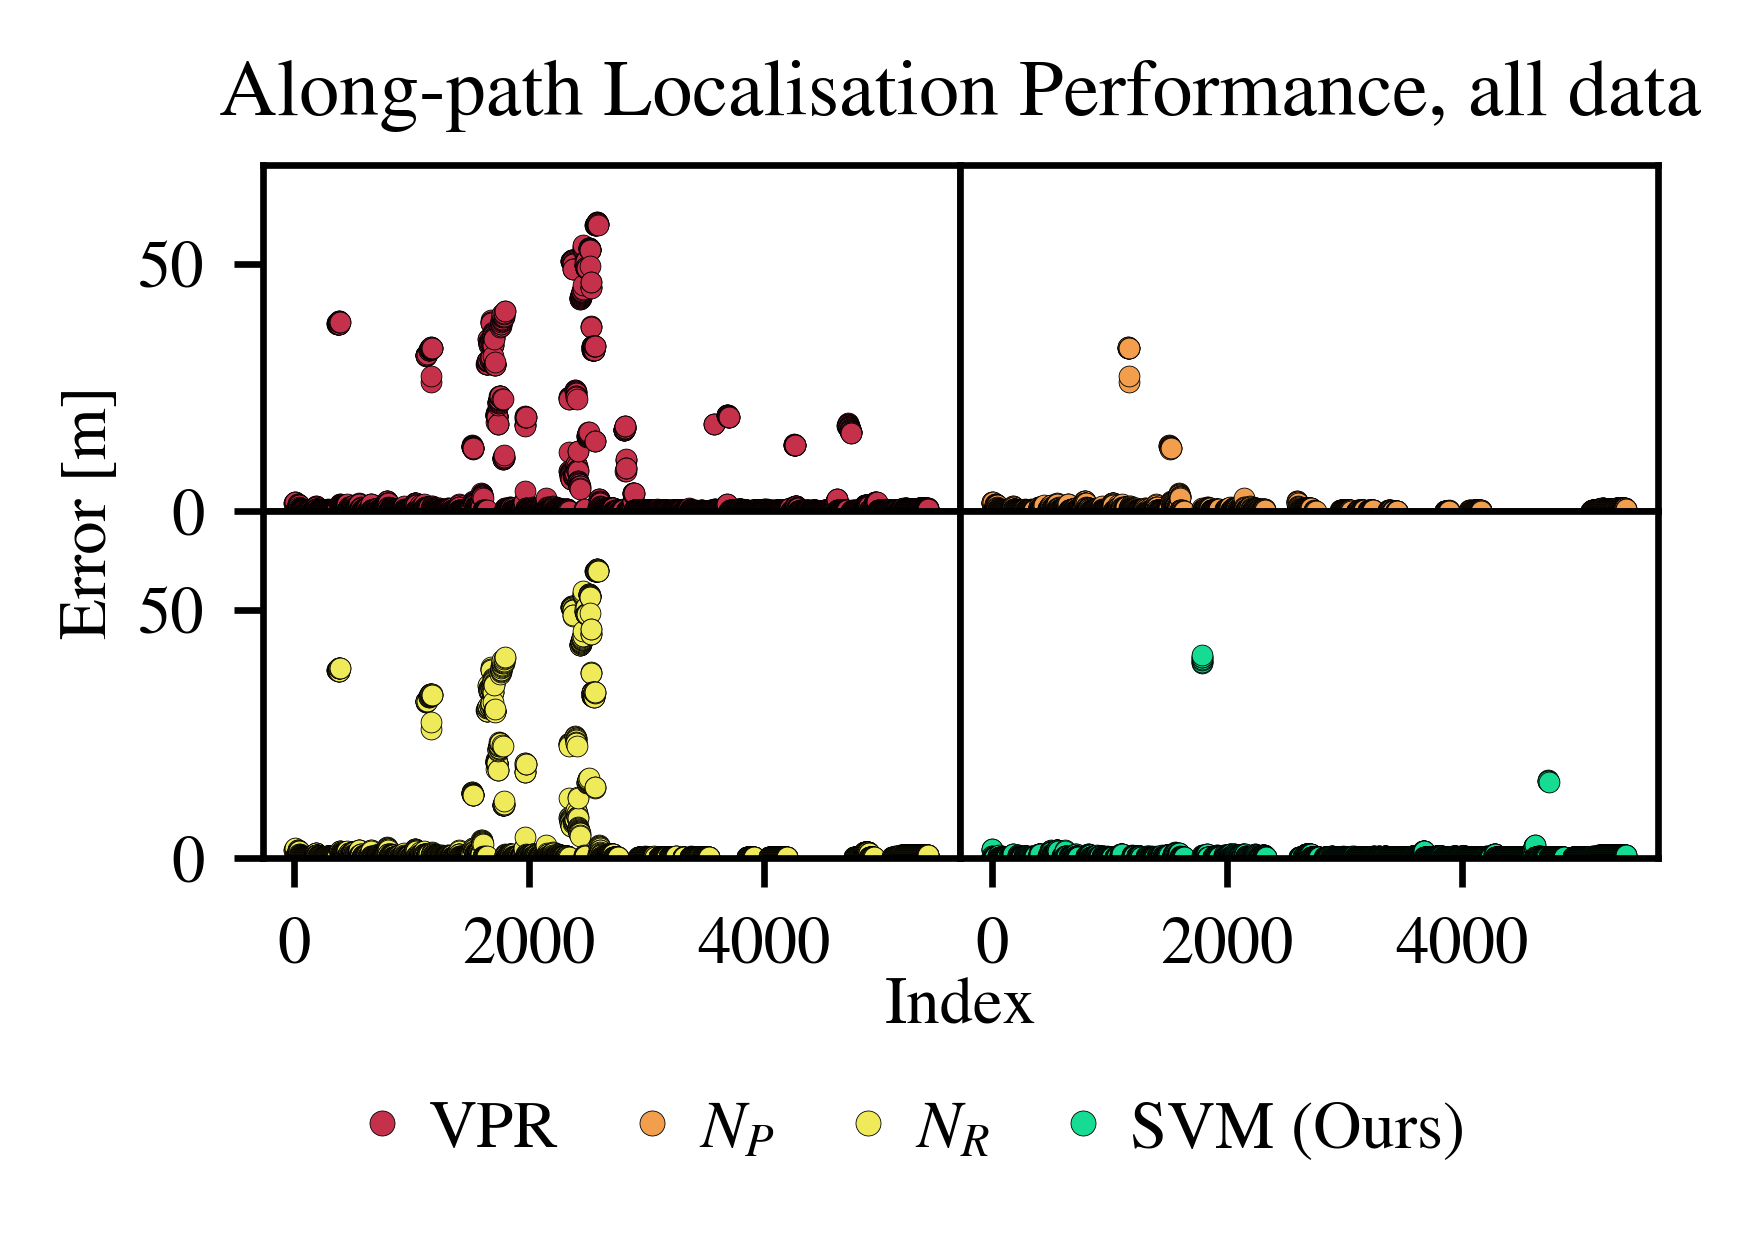

In [12]:
fig_26, axes_26 = plt.subplots(2,2, figsize=(3,1.5), sharex=True, sharey=True)
fig_26.subplots_adjust(hspace=0,wspace=0)
axes_26[0][0].tick_params(top=False, bottom=False, right=False)
axes_26[0][1].tick_params(top=False, bottom=False, left=False, right=False)
axes_26[1][0].tick_params(top=False, right=False)
axes_26[1][1].tick_params(top=False, left=False, right=False)
axes_26[0][0].plot(np.arange(len(df[df['mode']=='vpr']['pos_error'])), df[df['mode']=='vpr']['pos_error'], 'k.', markersize=5, markerfacecolor=cVPR, markeredgewidth=0.1)
axes_26[0][1].plot(np.arange(len(df[df['mode']=='nvp']['pos_error'])), df[df['mode']=='nvp']['pos_error'], 'k.', markersize=5, markerfacecolor=cNVP, markeredgewidth=0.1)
axes_26[1][0].plot(np.arange(len(df[df['mode']=='nvr']['pos_error'])), df[df['mode']=='nvr']['pos_error'], 'k.', markersize=5, markerfacecolor=cNVR, markeredgewidth=0.1)
axes_26[1][1].plot(np.arange(len(df[df['mode']=='svm']['pos_error'])), df[df['mode']=='svm']['pos_error'], 'k.', markersize=5, markerfacecolor=cSVM, markeredgewidth=0.1)
axes_26[1][0].set_ylim(0,70)


legend_elements = [
                    Line2D([0], [0], marker='.', label='VPR',        color=cVPR, linewidth=0, markeredgecolor='k', markeredgewidth=0.1),
                    Line2D([0], [0], marker='.', label='$N_P$',      color=cNVP, linewidth=0, markeredgecolor='k', markeredgewidth=0.1),
                    Line2D([0], [0], marker='.', label='$N_R$',      color=cNVR, linewidth=0, markeredgecolor='k', markeredgewidth=0.1),
                    Line2D([0], [0], marker='.', label='SVM (Ours)', color=cSVM, linewidth=0, markeredgecolor='k', markeredgewidth=0.1),
                ]
axes_26[1][0].legend(handles=legend_elements, loc='lower center', ncol=4, columnspacing=0.4, handletextpad=-0.3, frameon=False, bbox_to_anchor=(0.9,-1.05))

axes_26i = fig_26.add_subplot(111, frameon=False)
axes_26i.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axes_26i.set_ylabel('Error [m]', labelpad=0)
axes_26i.set_xlabel('Index', labelpad=0)
axes_26i.set_title('Along-path Localisation Performance, all data')

#### Single Case Examples

dict_keys(['gt_xyw', 'wo_xyw', 'mInd', 'mDist', 'tInd', 'tDist', 'gt_class', 'gt_err', 'svm_pred', 'svm_prob', 'svm_z', 'feats', 'naive_p', 'naive_r'])


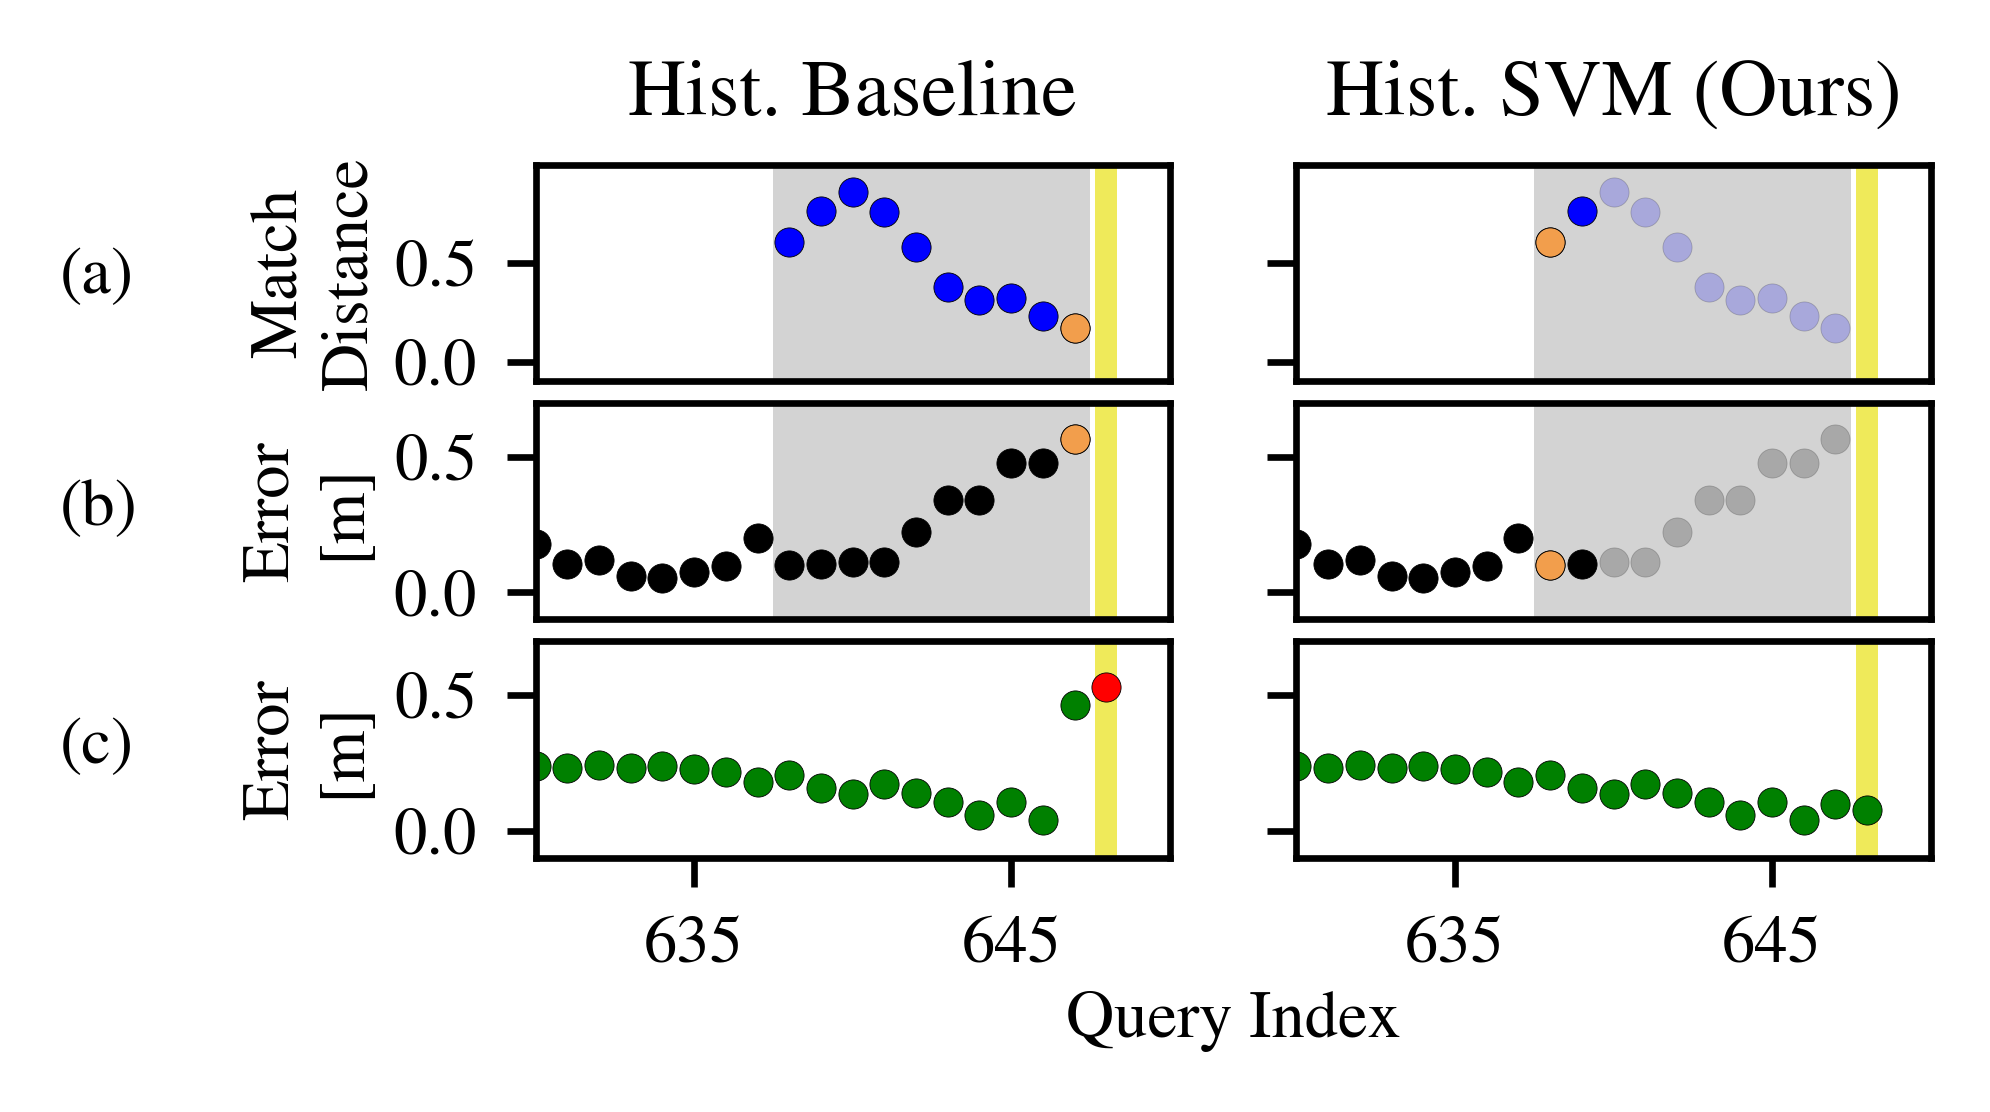

1.5281234016255638
0.5309817041422156 0.07598143537817659 0.8569038541527109


In [13]:
print(qd_ln.keys())

fig_2, axes_2 = plt.subplots(3,2,figsize=(3,1.5), sharex=True)

wo_sum, wo_len = calc_path_stats(qd_ln['wo_xyw'][:,0:2])

dd_ind_min     = np.argmin(abs(np.array(wo_sum) - 1.5)) + 1
dd_ind_max     = len(qd_ln['wo_xyw'])

gt_err = qd_ln['gt_err'][dd_ind_min:dd_ind_max]
mDist  = qd_ln['mDist'][dd_ind_min:dd_ind_max]
#mDist  = ((mDist - np.min(mDist)) / (np.max(mDist) - np.min(mDist)))
mDist  = (mDist - 3000) / 600
gt_wo_sum = wo_sum[dd_ind_min:dd_ind_max]
df_vpr_err = df[(df['set']=='Office\nNormal') & (df['mode']=='vpr')]['pos_error']
df_svm_err = df[(df['set']=='Office\nNormal') & (df['mode']=='svm')]['pos_error']

gt_in_tol = gt_err<=0.5
gt_discard = qd_ln['svm_pred'][dd_ind_min:dd_ind_max]
df_vpr_in_tol = df_vpr_err<=0.5
df_svm_in_tol = df_svm_err<=0.5
arange = np.arange(dd_ind_max-dd_ind_min)

for i in [0,1,2]:
    for j in [0,1]:
        axes_2[i][j].set_xlim(630,650)
        axes_2[i][j].add_patch(matplotlib.patches.Rectangle(xy=[647.65,-0.5],width=0.7,height=2,color=cNVR, alpha=1.0, linewidth=0))
        axes_2[i][j].set_yticks(np.arange(0, 0.6, step=0.5))
    #axes_2[i][2].axis('off')

axes_2[0][0].add_patch(matplotlib.patches.Rectangle(xy=[637.50, -0.5], width=10., height=2, alpha=1.0, linewidth=2, edgecolor='none', facecolor=cBLK))#, facecolor='none', edgecolor='r', linestyle='-'))
axes_2[0][1].add_patch(matplotlib.patches.Rectangle(xy=[637.50, -0.5], width=10., height=2, alpha=1.0, linewidth=2, edgecolor='none', facecolor=cBLK))#, facecolor='none', edgecolor='r', linestyle='-'))
axes_2[1][0].add_patch(matplotlib.patches.Rectangle(xy=[637.50, -0.5], width=10., height=2, alpha=1.0, linewidth=2, edgecolor='none', facecolor=cBLK))#, facecolor='none', edgecolor='r', linestyle='-'))
axes_2[1][1].add_patch(matplotlib.patches.Rectangle(xy=[637.50, -0.5], width=10., height=2, alpha=1.0, linewidth=2, edgecolor='none', facecolor=cBLK))#, facecolor='none', edgecolor='r', linestyle='-'))
axes_2[1][0].set_xticks(np.arange(635, 650, step=10))

fig_2.subplots_adjust(wspace=0.2, hspace=0.1)

ms=7

gtsdiscard = gt_discard[638:648]
mDistS = mDist[638:648]
arangeS = arange[638:648]

_lim = 649
gtldiscard = gt_discard[:_lim-1]
df_vpr_in_tol_l = df_vpr_in_tol[:_lim]
df_svm_in_tol_l = df_svm_in_tol[:_lim]
arangel = arange[:_lim-1]
arangeL = arange[:_lim]
gt_errL = gt_err[:_lim-1]
df_vpr_err_L = df_vpr_err[:_lim]
df_svm_err_L = df_svm_err[:_lim]

axes_2[0][0].plot(arange[638:648],           mDist[638:648],                 '.', color='b',    markeredgecolor='k', markeredgewidth=0.1, markersize=ms, alpha=1)
axes_2[0][0].plot(arangeS[9],                mDistS[9],                      '.', color=cNVP,   markeredgecolor='k', markeredgewidth=0.1, markersize=ms, alpha=1)
axes_2[0][1].plot(arangeS[gtsdiscard],       mDistS[gtsdiscard],             '.', color='b',    markeredgecolor='k', markeredgewidth=0.1, markersize=ms, alpha=1)
axes_2[0][1].plot(arangeS[~gtsdiscard],      mDistS[~gtsdiscard],            '.', color='b',    markeredgecolor='k', markeredgewidth=0.1, markersize=ms, alpha=0.2)
axes_2[0][1].plot(arangeS[0],                mDistS[0],                      '.', color=cNVP,   markeredgecolor='k', markeredgewidth=0.1, markersize=ms, alpha=1)

axes_2[1][0].plot(arangel,                   gt_errL,                        '.', color='k',    markeredgecolor='k', markeredgewidth=0.1, markersize=ms, alpha=1)
axes_2[1][0].plot(arangel[647],              gt_errL[647],                   '.', color=cNVP,   markeredgecolor='k', markeredgewidth=0.1, markersize=ms, alpha=1)
axes_2[1][1].plot(arangel[gtldiscard],       gt_errL[gtldiscard],            '.', color='k',    markeredgecolor='k', markeredgewidth=0.1, markersize=ms, alpha=1)
axes_2[1][1].plot(arangel[~gtldiscard],      gt_errL[~gtldiscard],           '.', color='k',    markeredgecolor='k', markeredgewidth=0.1, markersize=ms, alpha=0.2)
axes_2[1][1].plot(arangel[638],              gt_errL[638],                   '.', color=cNVP,   markeredgecolor='k', markeredgewidth=0.1, markersize=ms, alpha=1)

axes_2[2][0].plot(arangeL[~df_vpr_in_tol_l], df_vpr_err_L[~df_vpr_in_tol_l], '.', color='r',    markeredgecolor='k', markeredgewidth=0.1, markersize=ms, alpha=1)
axes_2[2][0].plot(arangeL[df_vpr_in_tol_l],  df_vpr_err_L[df_vpr_in_tol_l],  '.', color='g',    markeredgecolor='k', markeredgewidth=0.1, markersize=ms, alpha=1)
axes_2[2][1].plot(arangeL[~df_svm_in_tol_l], df_svm_err_L[~df_svm_in_tol_l], '.', color='r',    markeredgecolor='k', markeredgewidth=0.1, markersize=ms, alpha=1)
axes_2[2][1].plot(arangeL[df_svm_in_tol_l],  df_svm_err_L[df_svm_in_tol_l],  '.', color='g',    markeredgecolor='k', markeredgewidth=0.1, markersize=ms, alpha=1)

axes_2L = fig_2.add_subplot(111, frameon=False)
axes_2L.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)

axes_2[0][0].tick_params(axis='both', which='both', bottom=False, labelbottom=False)
axes_2[0][1].tick_params(axis='both', which='both', bottom=False, labelbottom=False, labelleft=False)
axes_2[1][0].tick_params(axis='both', which='both', bottom=False, labelbottom=False)
axes_2[1][1].tick_params(axis='both', which='both', bottom=False, labelbottom=False, labelleft=False)
axes_2[2][1].tick_params(axis='both', which='both', labelleft=False)

axes_2[0][0].set_ylabel('Match\nDistance',  labelpad=1.5)
axes_2[1][0].set_ylabel('Error\n[m]',       labelpad=2.4)
axes_2[2][0].set_ylabel('Error\n[m]',       labelpad=2.4)
axes_2L.set_xlabel('Query Index', labelpad=16)

axes_2[0][0].set_title('Hist. Baseline')
axes_2[0][1].set_title('Hist. SVM (Ours)')

axes_2[0][0].text(615,0.35,'(a)')
axes_2[1][0].text(615,0.25,'(b)')
axes_2[2][0].text(615,0.25,'(c)')

axes_2[0][0].set_ylim(-0.1,1.0)
axes_2[0][1].set_ylim(-0.1,1.0)
axes_2[1][0].set_ylim(-0.1,0.7)
axes_2[1][1].set_ylim(-0.1,0.7)
axes_2[2][0].set_ylim(-0.1,0.7)
axes_2[2][1].set_ylim(-0.1,0.7)
#axes_2[i][j].set_yticks(np.arange(0, 0.7, step=0.6))


axes_2[0][0].yaxis.set_major_formatter(_formatter)

plt.show()

print(gt_wo_sum[648]-gt_wo_sum[628])
print(np.array(df_vpr_err_L)[-1],np.array(df_svm_err_L)[-1], (np.array(df_vpr_err_L)[-1]-np.array(df_svm_err_L)[-1])/np.array(df_vpr_err_L)[-1])

path = 'media/single_case_example' #relative to file directory
fig_2.savefig(path+'.pdf', format='pdf', dpi=1000, pad_inches=0, bbox_inches='tight')
fig_2.savefig(path+'.png', format='png', dpi=1000, pad_inches=0, bbox_inches='tight')

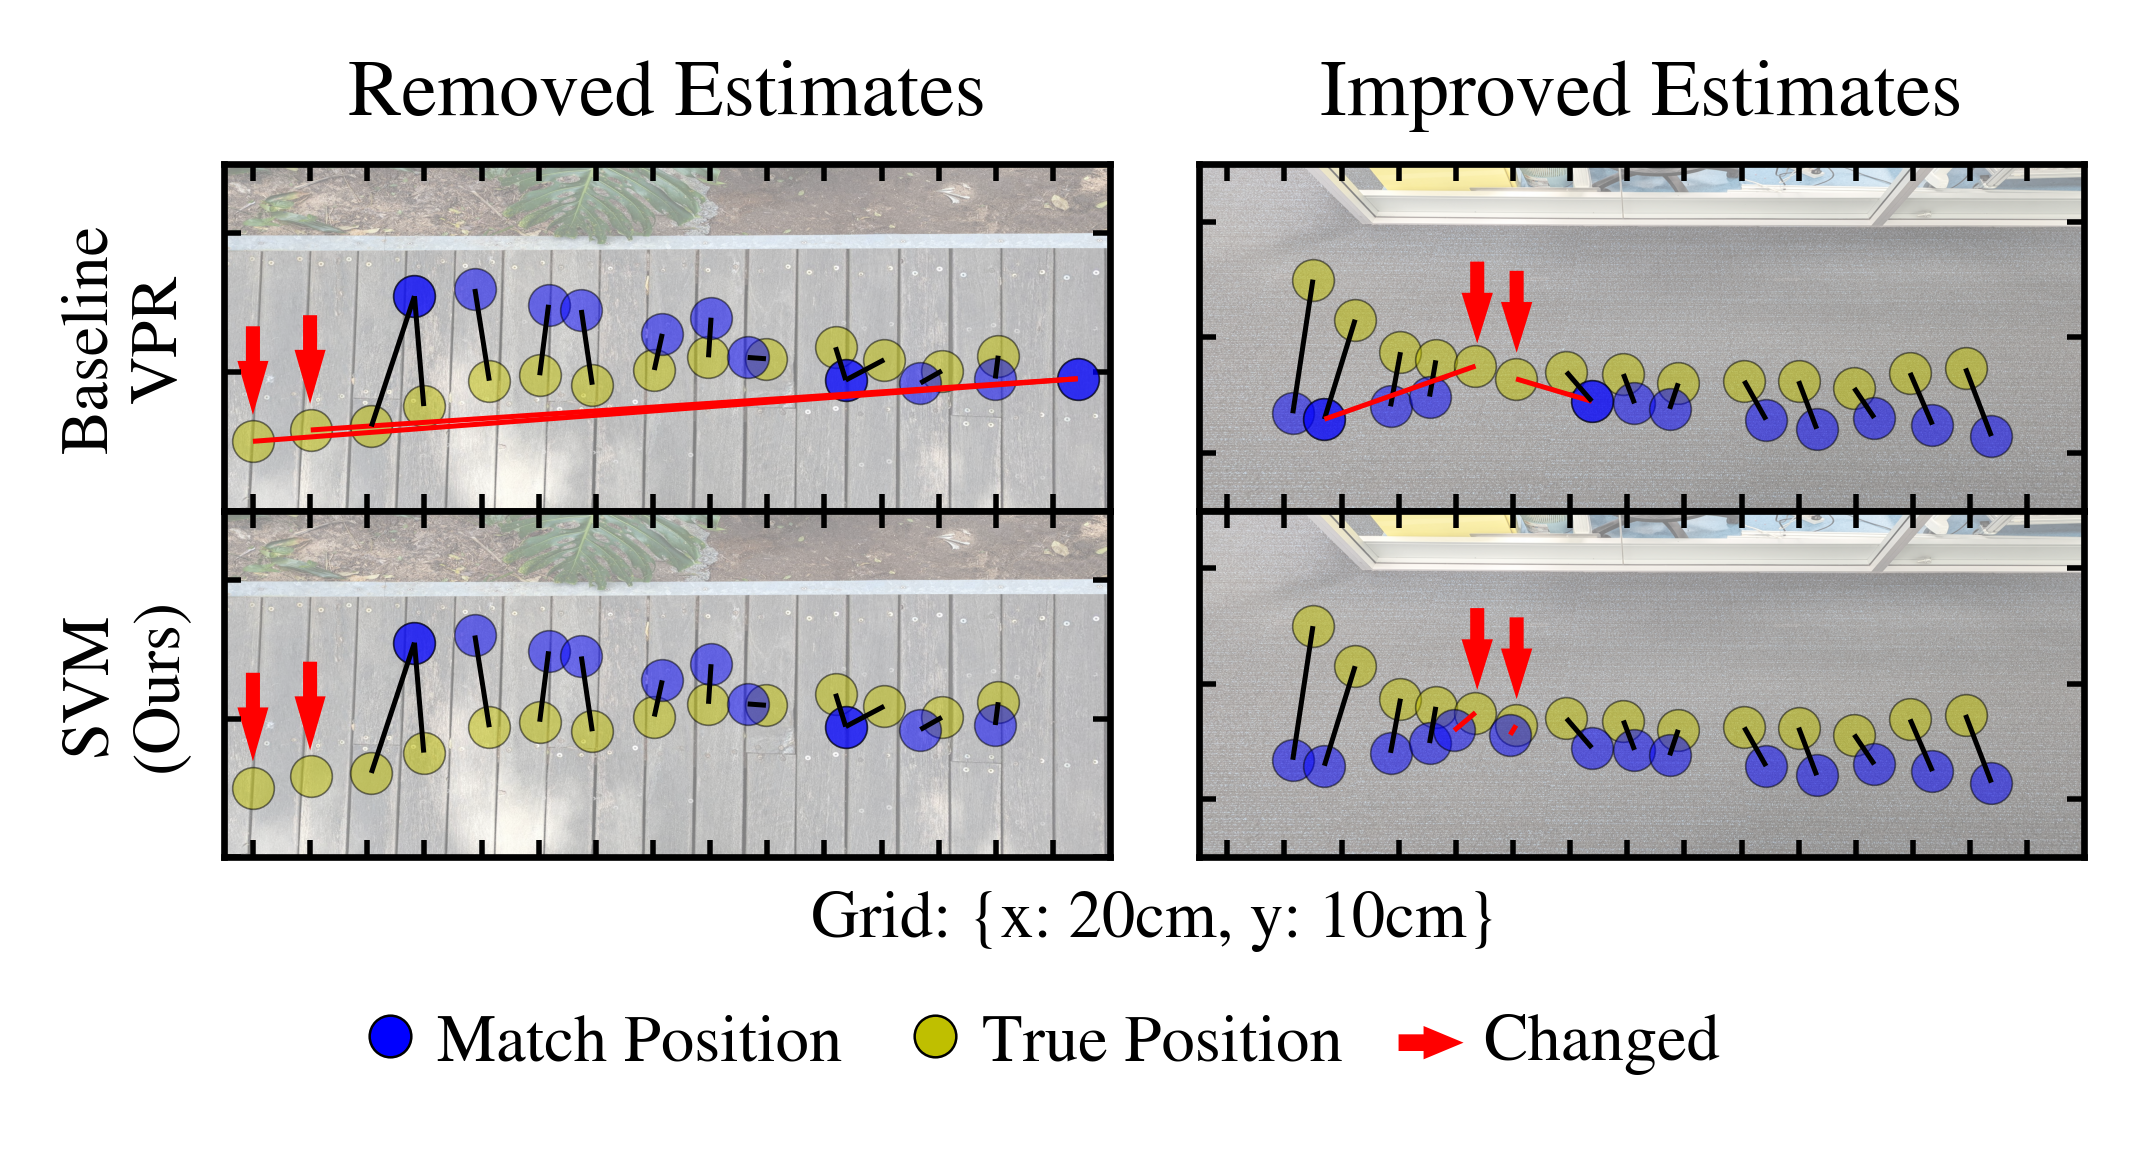

In [14]:
fig_5, axes_5 = plt.subplots(2,2,figsize=(4,1.5))

_step = 2
_shared_style = dict(marker='.', linestyle='none', alpha=0.5, markersize=10, markeredgecolor='k', markeredgewidth=0.2)
lines_style = dict(linewidths=0.6)

_qd_hash = {'Office\nNormal': qd_ln, 'Office\nAdverse': qd_la, 'Campus\nNormal': qd_cn, 'Campus\nAdverse': qd_ca}
_ip_hash = {'Office\nNormal': ln_ref_ip.dataset['dataset'], 'Office\nAdverse': la_ref_ip.dataset['dataset'], 'Campus\nNormal': cn_ref_ip.dataset['dataset'], 'Campus\nAdverse': ca_ref_ip.dataset['dataset']}

bgimg1 = matplotlib.image.imread('media/outdoors_2a.jpg')
bgimg2 = matplotlib.image.imread('media/carpet_2.jpg')

_env    = 'Campus'
_cond   = 'Normal'
_set    = _env+'\n'+_cond
_qd     = _qd_hash[_set]
_ip     = _ip_hash[_set]

wo_sum, wo_len = calc_path_stats(_qd['wo_xyw'][:,0:2])
dd_ind_min     = np.argmin(abs(np.array(wo_sum) - 1.5)) + 1
dd_ind_max     = len(_qd['wo_xyw'])

_min    = 1600
_max    = np.min([_min + 28, dd_ind_max-dd_ind_min])
_slice  = slice(_min,_max, _step)
dd      = slice(dd_ind_min, dd_ind_max+1)

_os       = _qd['gt_xyw'][dd][_slice][0]
gt_xyw    = _qd['gt_xyw'][dd][_slice] - _os
xyw_vpr   = np.array([[_ip['p'+j][i] for j in 'xyw'] for i in df[(df['mode']=='vpr') & (df['set']==_set)]['lInd']])[_slice] - _os
xyw_svm   = np.array([[_ip['p'+j][i] for j in 'xyw'] if not np.isnan(i) else [np.nan]*3 for i in df[(df['mode']=='svm') & (df['set']==_set)]['lInd']])[_slice] - _os
lines_vpr = [[(gt_xyw[i,0], gt_xyw[i,1]), (xyw_vpr[i,0],xyw_vpr[i,1])] for i in range(len(gt_xyw))]
lines_svm = [[(gt_xyw[i,0], gt_xyw[i,1]), (xyw_svm[i,0],xyw_svm[i,1])] for i in range(len(gt_xyw))]

axes_5[0][0].plot(gt_xyw[:,0],   gt_xyw[:,1],   markerfacecolor='y', **_shared_style)
axes_5[0][0].plot(xyw_vpr[:,0],  xyw_vpr[:,1],  markerfacecolor='b', **_shared_style)
axes_5[0][0].add_collection(matplotlib.collections.LineCollection(lines_vpr, **lines_style, colors=('r','r','k','k','k','k','k','k','k','k','k','k','k','k','k')))

axes_5[1][0].plot(gt_xyw[:,0],   gt_xyw[:,1],   markerfacecolor='y', **_shared_style, label='True Position')
axes_5[1][0].plot(xyw_svm[:,0],  xyw_svm[:,1],  markerfacecolor='b', **_shared_style, label='Match Position')
axes_5[1][0].add_collection(matplotlib.collections.LineCollection(lines_svm, **lines_style, colors=('r','r','k','k','k','k','k','k','k','k','k','k','k','k','k')))

_env    = 'Office'
_cond   = 'Normal'
_set    = _env+'\n'+_cond
_qd     = _qd_hash[_set]
_ip     = _ip_hash[_set]

wo_sum, wo_len = calc_path_stats(_qd['wo_xyw'][:,0:2])
dd_ind_min     = np.argmin(abs(np.array(wo_sum) - 1.5)) + 1
dd_ind_max     = len(_qd['wo_xyw'])

_min    = 640
_max    = np.min([_min + 28, dd_ind_max-dd_ind_min])
_slice  = slice(_min,_max, _step)
dd      = slice(dd_ind_min, dd_ind_max+1)


tb = Transform_Builder()
_H = tb.rotate(0,0,-5,radians=False).translate(0.3,0,0).get()

_os         = _qd['gt_xyw'][dd][_slice][0]
gt_xyw_R    = _qd['gt_xyw'][dd][_slice] - _os
xyw_vpr_R   = np.array([[_ip['p'+j][i] for j in 'xyw'] for i in df[(df['mode']=='vpr') & (df['set']==_set)]['lInd']])[_slice] - _os
xyw_svm_R   = np.array([[_ip['p'+j][i] for j in 'xyw'] if not np.isnan(i) else [np.nan]*3 for i in df[(df['mode']=='svm') & (df['set']==_set)]['lInd']])[_slice] - _os
gt_x, gt_y, _   = apply_homogeneous_transform(_H, gt_xyw_R[:,0], gt_xyw_R[:,1])
vpr_x, vpr_y, _ = apply_homogeneous_transform(_H, xyw_vpr_R[:,0], xyw_vpr_R[:,1])
svm_x, svm_y, _ = apply_homogeneous_transform(_H, xyw_svm_R[:,0], xyw_svm_R[:,1])
gt_xyw          = np.transpose(np.array([gt_x, gt_y]))
xyw_vpr         = np.transpose(np.array([vpr_x, vpr_y]))
xyw_svm         = np.transpose(np.array([svm_x, svm_y]))

lines_vpr = [[(gt_xyw[i,0], gt_xyw[i,1]), (xyw_vpr[i,0],xyw_vpr[i,1])] for i in range(len(gt_xyw))]
lines_svm = [[(gt_xyw[i,0], gt_xyw[i,1]), (xyw_svm[i,0],xyw_svm[i,1])] for i in range(len(gt_xyw))]

axes_5[0][1].plot(gt_xyw[:,0],   gt_xyw[:,1],   markerfacecolor='y', **_shared_style)
axes_5[0][1].plot(xyw_vpr[:,0],  xyw_vpr[:,1],  markerfacecolor='b', **_shared_style)
axes_5[0][1].add_collection(matplotlib.collections.LineCollection(lines_vpr, **lines_style, colors=('k','k','k','k','r','r','k','k','k','k','k','k','k')))

axes_5[1][1].plot(gt_xyw[:,0],   gt_xyw[:,1],   markerfacecolor='y', **_shared_style, label='True Position')
axes_5[1][1].plot(xyw_svm[:,0],  xyw_svm[:,1],  markerfacecolor='b', **_shared_style, label='Match Position')
axes_5[1][1].add_collection(matplotlib.collections.LineCollection(lines_svm, **lines_style, colors=('k','k','k','k','r','r','k','k','k','k','k','k','k')))

for i in [0,1]:
    for j in [0,1]:
        axes_5[i][j].grid('on')
        axes_5[i][j].tick_params(axis='both', which='both', direction='in', labelleft=False, labelbottom=False, right=True, top=True, length=2, width=0.66, grid_linewidth=0.2, grid_color='none', grid_alpha=0.8)

axes_5[0][0].set_ylabel('Baseline\nVPR')
axes_5[1][0].set_ylabel('SVM\n(Ours)')
axes_5[0][0].set_title('Removed Estimates')
axes_5[0][1].set_title('Improved Estimates')
fig_5.subplots_adjust(hspace=0, wspace=0.1)

axes_5i = fig_5.add_subplot(111, frameon=False)
axes_5i.tick_params(axis='both', which='both', labelleft=False, labelbottom=False, left=False, bottom=False)
axes_5i.set_xlabel(r'Grid: {x: 20cm, y: 10cm}')

_arrow = dict(width=0.02, head_width=0.07, length_includes_head=True, overhang=0, color='r')

y1=0.03
y2=0.02
axes_5[0][0].arrow(             x=0.000, y= 0.110-y1, dx=0, dy=-0.050, head_length=0.025, **_arrow, label='Changed')
axes_5[0][0].arrow(             x=0.200, y= 0.118-y1, dx=0, dy=-0.050, head_length=0.025, **_arrow, label='Changed')
axes_5[1][0].arrow(             x=0.000, y= 0.110-y1, dx=0, dy=-0.050, head_length=0.025, **_arrow, label='Changed')
axes_5[1][0].arrow(             x=0.200, y= 0.118-y1, dx=0, dy=-0.050, head_length=0.025, **_arrow, label='Changed')

axes_5[0][1].arrow(             x=0.875, y= 0.032-y2, dx=0, dy=-0.055, head_length=0.028, **_arrow, label='Changed')
axes_5[0][1].arrow(             x=1.013, y= 0.024-y2, dx=0, dy=-0.055, head_length=0.028, **_arrow, label='Changed')
axes_5[1][1].arrow(             x=0.875, y= 0.032-y2, dx=0, dy=-0.055, head_length=0.028, **_arrow, label='Changed')
plt_arrow = axes_5[1][1].arrow( x=1.013, y= 0.024-y2, dx=0, dy=-0.055, head_length=0.028, **_arrow, label='Changed')


legend_elements = [ Line2D([0], [0], marker='.', label='Match Position', color='k',  linewidth=0, markersize=10, markerfacecolor='b', markeredgewidth=0.3),
                    Line2D([0], [0], marker='.', label='True Position',  color='k',  linewidth=0, markersize=10, markerfacecolor='y', markeredgewidth=0.3),
                    plt_arrow,
                ]
lgnd = axes_5[1][0].legend(handles=legend_elements, loc='lower center', ncol=3, columnspacing=0.4, handletextpad=-0.3, frameon=False, bbox_to_anchor=(0.9,-0.8), handler_map={matplotlib.patches.FancyArrow : matplotlib.legend_handler.HandlerPatch(patch_func=make_legend_arrow),
                    })

axes_5[0][0].imshow(bgimg1[20:,:], extent=[-0.1, 3, -0.05, 0.20], alpha=0.5)
axes_5[0][0].set_aspect('auto')
axes_5[1][0].imshow(bgimg1[20:,:], extent=[-0.1, 3, -0.05, 0.20], alpha=0.5)
axes_5[1][0].set_aspect('auto')

axes_5[0][1].imshow(bgimg2[:,:], extent=[-0.1, 3, -0.20, 0.10], alpha=0.5)
axes_5[0][1].set_aspect('auto')
axes_5[1][1].imshow(bgimg2[:,:], extent=[-0.1, 3, -0.20, 0.10], alpha=0.5)
axes_5[1][1].set_aspect('auto')

axes_5[0][0].set_xticks(np.arange(0,3,0.2))
axes_5[1][0].set_xticks(np.arange(0,3,0.2))
axes_5[0][1].set_xticks(np.arange(0,3,0.2))
axes_5[1][1].set_xticks(np.arange(0,3,0.2))

axes_5[0][0].set_yticks(np.arange(-0.15,0.35,0.1))
axes_5[1][0].set_yticks(np.arange(-0.15,0.35,0.1))
axes_5[0][1].set_yticks(np.arange(-0.25,0.25,0.1))
axes_5[1][1].set_yticks(np.arange(-0.25,0.25,0.1))

axes_5[0][0].set_ylim(-0.05,0.20)
axes_5[1][0].set_ylim(-0.05,0.20)
axes_5[0][1].set_ylim(-0.20,0.10)
axes_5[1][1].set_ylim(-0.20,0.10)

plt.show()


path = 'media/exp2_along_path_example' #relative to file directory
fig_5.savefig(path+'.pdf', format='pdf', bbox_extra_artists=(lgnd,), dpi=1000, pad_inches=0, bbox_inches='tight')
fig_5.savefig(path+'.png', format='png', bbox_extra_artists=(lgnd,), dpi=1000, pad_inches=0, bbox_inches='tight')